In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import re
import mlflow
import shap

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

from contextlib import contextmanager

from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

from catboost import CatBoostClassifier

from xgboost import XGBClassifier

from joblib import dump

D:\anaconda3\envs\projet7\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
D:\anaconda3\envs\projet7\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=1

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit fo

In [2]:
print('Versions des librairies ',
      'pandas : ',pd.__version__,
      ', numpy : ',np.__version__,
      ', seaborn : ',sns.__version__,
      ', mlflow : ',mlflow.__version__)

Versions des librairies  pandas :  2.0.2 , numpy :  1.23.5 , seaborn :  0.12.2 , mlflow :  2.3.2


In [3]:
pd.set_option('Display.max_columns',None)

## Sommaire :

<a href='#1'> 1) EDA
  - <a href='#1a'> app_train
      - <a href='#1a1'> Valeurs manquantes
      - <a href='#1a2'> Valeurs aberrantes
      - <a href='#1a4'> Corrélations
      - <a href='#1a5'> Séparation du jeu d'entraînement
  - <a href='#1b'> app_test
  - <a href='#1c'> bureau
  - <a href='#1d'> bureau_balance
  - <a href='#1e'> credit_card_balance
  - <a href='#1f'> HomeCredit_columns_description
  - <a href='#1g'> installments_payments
  - <a href='#1h'> POS_CASH_balance
  - <a href='#1i'> previous_application
  - <a href='#1j'> sample_submission

<a href='#2'> 2) Feature engineering
    
<a href='#3'> 3) MLTracking
    
<a href='#4'> 4) Modélisation
  - <a href='#4a'> Dummy classifier
  - <a href='#4b'> Regression logistique
  - <a href='#4c'> HistGradientBoostingClassifier
  - <a href='#4d'> KNeighborsClassifier
  - <a href='#4e'> CatBoostClassifier
  - <a href='#4f'> XGBoostClassifier
  - <a href='#4g'> LGBMClassifier
  - <a href='#4h'> Modèle retenu
    
<a href='#5'> 5) Feature importance
    
<a href='#6'> 6) Sauvegardes
    
<a href='#7'> 7) Data drift

# <a name='1'> 1) EDA

## <a name='1a'> app_train

In [4]:
app_train = pd.read_csv('application_train.csv')
app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [5]:
app_train.shape

(307511, 122)

Ce fichier comporte 307 511 lignes et 122 colonnes. Chaque ligne est une demande de prêt chez Home Credit identifié par SK_ID_CURR.

La TARGET est à 1 si le client est en difficulté de paiement (il a eu un retard de paiement de plus de X jours sur au moins Y premières échéances du crédit).

Pour chaque prêt, nous connaissons le type de contrat et de nombreuses informations sur le client.

In [6]:
# Type des colonnes
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [7]:
# Nombre de valeurs différentes par colonne catégorielle
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [8]:
cibles = app_train['TARGET']
cibles.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

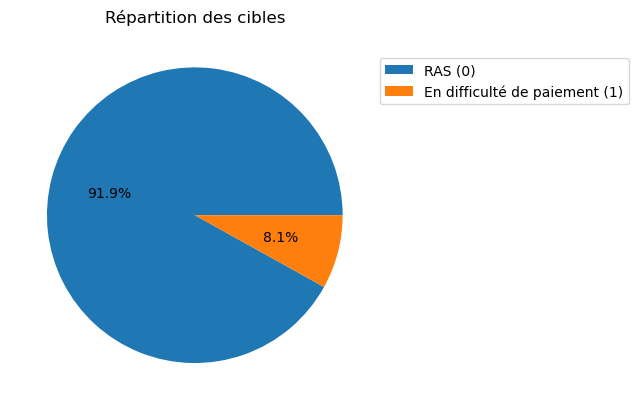

In [9]:
plt.pie(cibles.value_counts(), autopct = '%1.1f%%')
plt.title('Répartition des cibles')
plt.legend(['RAS (0)', 'En difficulté de paiement (1)'], loc = (1,0.8))
plt.show()

Nous voyons que les classes sont déséquilibrées. Il y a beaucoup plus de prêt remboursés à temps.

### <a name='1a1'> Valeurs manquantes

In [10]:
# Fonction qui calcule les valeurs manquantes par colonne

def missing_values_table(df):
        # Total missing values
        mis_val = df.isna().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isna().mean()
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print("Votre dataframe a " + str(df.shape[1]) + " colonnes.\n",      
            str(mis_val_table_ren_columns.shape[0]) +
              " colonnes ont des valeurs manquantes")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [11]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Votre dataframe a 122 colonnes.
 67 colonnes ont des valeurs manquantes


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

In [12]:
# Vérification qu'il n'y a pas de doublons
app_train.duplicated().sum()

0

### <a name='1a2'> Valeurs aberrantes

In [13]:
app_train.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

In [14]:
(app_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Les valeurs sont cohérentes.

In [15]:
(app_train['DAYS_EMPLOYED']/ 365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

La plus grande valeur est à 1 000 ans !!!

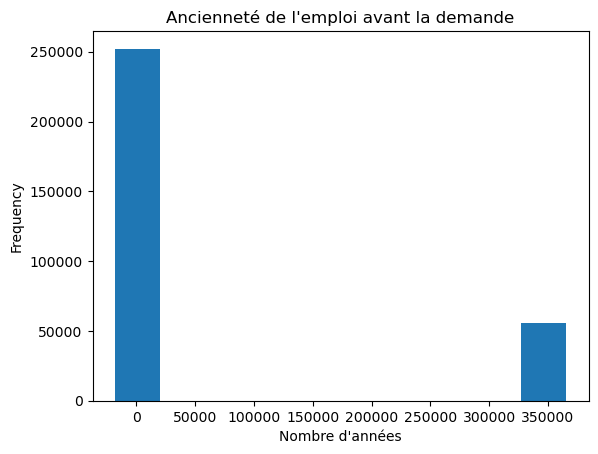

In [16]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Ancienneté de l\'emploi avant la demande')
plt.xlabel('Nombre d\'années')
plt.show()

In [17]:
app_train.loc[app_train['DAYS_EMPLOYED'] > 300000, 'DAYS_EMPLOYED'].describe()

count     55374.0
mean     365243.0
std           0.0
min      365243.0
25%      365243.0
50%      365243.0
75%      365243.0
max      365243.0
Name: DAYS_EMPLOYED, dtype: float64

55 374 demandes ont une erreur sur 'DAYS_EMPLOYED', toutes égales à 365 243.

In [18]:
app_train['DAYS_EMPLOYED'].isna().sum()

0

Aucune valeur manquante pour cette variable. Nous remplaçons la valeur aberrante 365 243 par np.nan.

In [19]:
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

In [20]:
app_train['CODE_GENDER'].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

Nous supprimons les 4 lignes qui ont XNA pour CODE_GENDER.

In [21]:
app_train = app_train[app_train['CODE_GENDER'] != 'XNA']

### <a name='1a4'> Corrélations

Quelques interprétations générales de la valeur absolue du coefficient de corrélation :
   - 0-0.19 "très faible"
   - 0.2-0.39 "faible"
   - 0.4-0.59 "modéré"
   - 0.6-0.79 "fort"
   - 0.8-1 "très fort"

In [22]:
var_num = app_train.select_dtypes(['int','float']).columns.to_list()
correlations = app_train[var_num].corr()['TARGET'].sort_values(ascending = False)

In [23]:
# Les 10 plus importantes corrélations positives
correlations.head(10)

TARGET                         1.000000
DAYS_BIRTH                     0.078242
DAYS_EMPLOYED                  0.074957
REGION_RATING_CLIENT_W_CITY    0.060895
REGION_RATING_CLIENT           0.058901
DAYS_LAST_PHONE_CHANGE         0.055219
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050992
FLAG_EMP_PHONE                 0.045984
REG_CITY_NOT_LIVE_CITY         0.044394
Name: TARGET, dtype: float64

In [24]:
# Les 10 plus importantes corrélations négatives
correlations.tail(10)

ELEVATORS_MEDI               -0.033866
ELEVATORS_AVG                -0.034202
REGION_POPULATION_RELATIVE   -0.037225
AMT_GOODS_PRICE              -0.039647
FLOORSMAX_MODE               -0.043231
FLOORSMAX_MEDI               -0.043773
FLOORSMAX_AVG                -0.044009
EXT_SOURCE_1                 -0.155317
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_3                 -0.178926
Name: TARGET, dtype: float64

In [25]:
# # Les 10 plus importantes corrélations
(abs(correlations)).sort_values(ascending = False).head(10)

TARGET                         1.000000
EXT_SOURCE_3                   0.178926
EXT_SOURCE_2                   0.160471
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078242
DAYS_EMPLOYED                  0.074957
REGION_RATING_CLIENT_W_CITY    0.060895
REGION_RATING_CLIENT           0.058901
DAYS_LAST_PHONE_CHANGE         0.055219
DAYS_ID_PUBLISH                0.051457
Name: TARGET, dtype: float64

Les 3 variables numériques les plus influentes sont des données extérieures. Mettons les de côté.
Ensuite, on a la variable 'DAYS_BIRTH'. Regardons la de plus près.

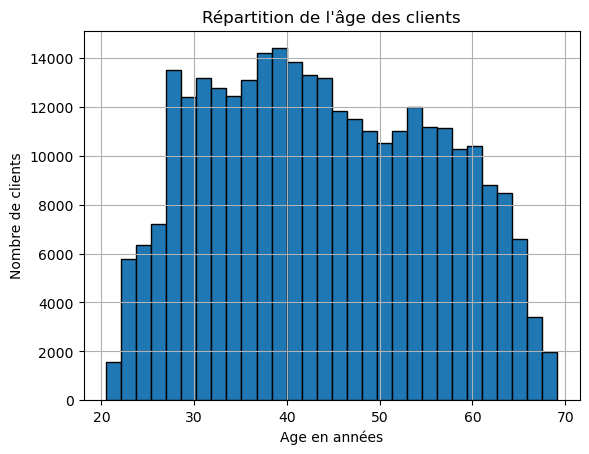

In [26]:
(app_train['DAYS_BIRTH']/-365).hist(bins=30, edgecolor = 'k')
plt.title('Répartition de l\'âge des clients')
plt.xlabel('Age en années')
plt.ylabel('Nombre de clients')
plt.show()

Rien de particulier.

Regroupons par tranche d'âge et regardons le ratio de prêts non remboursés.

In [27]:
df_age = app_train[['TARGET', 'DAYS_BIRTH']]
df_age['YEARS_BIRTH'] = df_age['DAYS_BIRTH']/-365
df_age['Tranche_age'] = pd.cut(df_age['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
df_age.head()

TARGET  DAYS_BIRTH  YEARS_BIRTH   Tranche_age
0       1       -9461    25.920548  (25.0, 30.0]
1       0      -16765    45.931507  (45.0, 50.0]
2       0      -19046    52.180822  (50.0, 55.0]
3       0      -19005    52.068493  (50.0, 55.0]
4       0      -19932    54.608219  (50.0, 55.0]

In [28]:
age_groupe = df_age.groupby('Tranche_age').mean()
age_groupe

TARGET    DAYS_BIRTH  YEARS_BIRTH
Tranche_age                                      
(20.0, 25.0]  0.123036  -8532.795625    23.377522
(25.0, 30.0]  0.111442 -10155.219690    27.822520
(30.0, 35.0]  0.102814 -11854.848377    32.479037
(35.0, 40.0]  0.089416 -13707.908041    37.555912
(40.0, 45.0]  0.078491 -15497.661233    42.459346
(45.0, 50.0]  0.074171 -17323.900441    47.462741
(50.0, 55.0]  0.066968 -19196.494791    52.593136
(55.0, 60.0]  0.055316 -20984.285455    57.491193
(60.0, 65.0]  0.052737 -22780.547460    62.412459
(65.0, 70.0]  0.037270 -24292.614340    66.555108

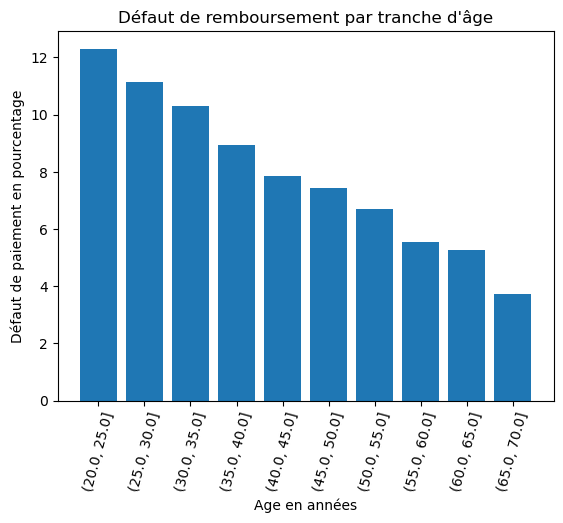

In [29]:
plt.bar(age_groupe.index.astype(str), age_groupe['TARGET']*100)
plt.title('Défaut de remboursement par tranche d\'âge')
plt.xlabel('Age en années')
plt.ylabel('Défaut de paiement en pourcentage')
plt.xticks(rotation = 75)
plt.show()

On voit clairement que plus les clients sont jeunes, plus le défaut de paiement est important.

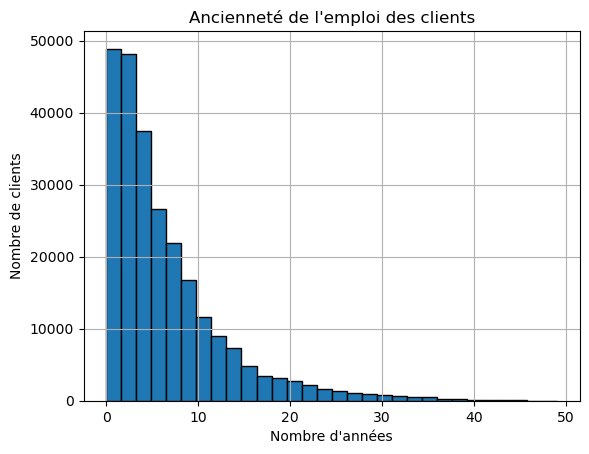

In [30]:
(app_train['DAYS_EMPLOYED']/-365).hist(bins = 30, edgecolor = 'k')
plt.title('Ancienneté de l\'emploi des clients')
plt.xlabel('Nombre d\'années')
plt.ylabel('Nombre de clients')
plt.show()

In [31]:
df_emp = app_train[['TARGET', 'DAYS_EMPLOYED']]
df_emp['YEARS_EMP'] = df_emp['DAYS_EMPLOYED']/-365
df_emp['Tranche_age'] = pd.cut(df_emp['YEARS_EMP'], bins = np.linspace(0, 50, num = 11))
df_emp.head()

TARGET  DAYS_EMPLOYED  YEARS_EMP  Tranche_age
0       1         -637.0   1.745205   (0.0, 5.0]
1       0        -1188.0   3.254795   (0.0, 5.0]
2       0         -225.0   0.616438   (0.0, 5.0]
3       0        -3039.0   8.326027  (5.0, 10.0]
4       0        -3038.0   8.323288  (5.0, 10.0]

In [32]:
emp_groupe = df_emp.groupby('Tranche_age').mean()
emp_groupe

TARGET  DAYS_EMPLOYED  YEARS_EMP
Tranche_age                                     
(0.0, 5.0]    0.105709    -864.338095   2.368050
(5.0, 10.0]   0.073717   -2630.227316   7.206102
(10.0, 15.0]  0.057752   -4466.899670  12.238081
(15.0, 20.0]  0.048484   -6306.860448  17.279070
(20.0, 25.0]  0.047573   -8092.875701  22.172262
(25.0, 30.0]  0.039915   -9961.412156  27.291540
(30.0, 35.0]  0.041258  -11791.751418  32.306168
(35.0, 40.0]  0.019231  -13517.634615  37.034615
(40.0, 45.0]  0.004762  -15325.461905  41.987567
(45.0, 50.0]  0.000000  -16862.916667  46.199772

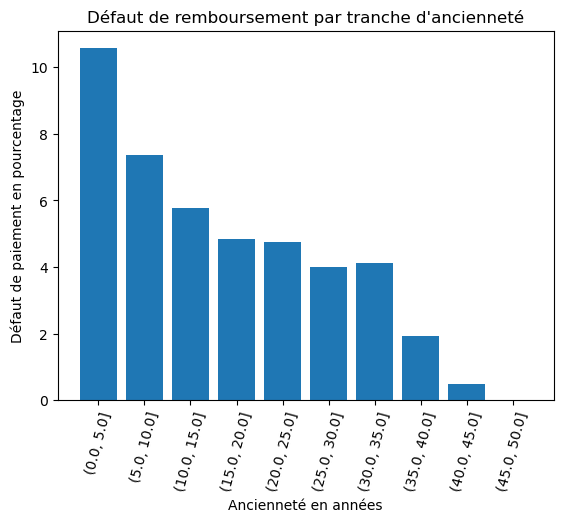

In [33]:
plt.bar(emp_groupe.index.astype(str), emp_groupe['TARGET']*100)
plt.title('Défaut de remboursement par tranche d\'ancienneté')
plt.xlabel('Ancienneté en années')
plt.ylabel('Défaut de paiement en pourcentage')
plt.xticks(rotation = 75)
plt.show()

On voit clairement que plus l'ancienneté est grande, moins le défaut de paiement est important, en cohérence avec l'analyse précédente sur l'âge.

Ensuite, nous avons les variabes 'REGION_RATING_CLIENT' et 'REGION_RATING_CLIENT_W_CITY' qui donnent à un score de localisation : 1, 2 ou 3.

In [34]:
app_train['REGION_RATING_CLIENT'].value_counts()

REGION_RATING_CLIENT
2    226981
3     48329
1     32197
Name: count, dtype: int64

In [35]:
app_train['REGION_RATING_CLIENT_W_CITY'].value_counts()

REGION_RATING_CLIENT_W_CITY
2    229481
3     43859
1     34167
Name: count, dtype: int64

In [36]:
app_train.loc[app_train['REGION_RATING_CLIENT'] != app_train['REGION_RATING_CLIENT_W_CITY'], 'TARGET'].value_counts(normalize = True)

TARGET
0    0.925848
1    0.074152
Name: proportion, dtype: float64

Il n'y a que 5 718 demandes où les 2 scores ne sont pas identiques. La répartition des targets est identique à l'ensemble du dataset (92% de 0).

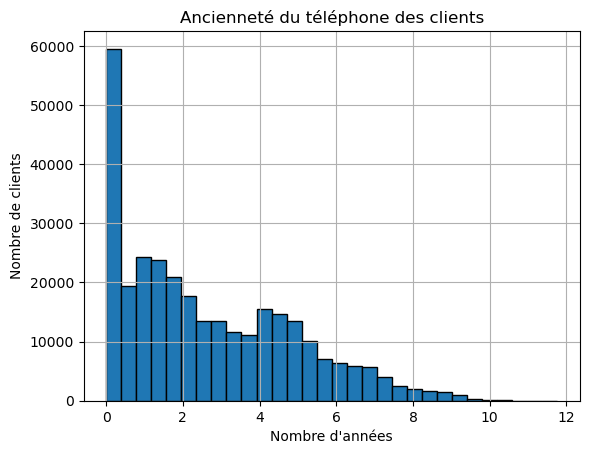

In [37]:
(app_train['DAYS_LAST_PHONE_CHANGE']/-365).hist(bins = 30, edgecolor = 'k')
plt.title('Ancienneté du téléphone des clients')
plt.xlabel('Nombre d\'années')
plt.ylabel('Nombre de clients')
plt.show()

In [38]:
df_emp = app_train[['TARGET', 'DAYS_LAST_PHONE_CHANGE']]
df_emp['YEARS_PHONE'] = df_emp['DAYS_LAST_PHONE_CHANGE']/-365
df_emp['Tranche_annee'] = pd.cut(df_emp['YEARS_PHONE'], bins = np.linspace(0, 11, num = 12))
df_emp.head()

TARGET  DAYS_LAST_PHONE_CHANGE  YEARS_PHONE Tranche_annee
0       1                 -1134.0     3.106849    (3.0, 4.0]
1       0                  -828.0     2.268493    (2.0, 3.0]
2       0                  -815.0     2.232877    (2.0, 3.0]
3       0                  -617.0     1.690411    (1.0, 2.0]
4       0                 -1106.0     3.030137    (3.0, 4.0]

In [39]:
phone_groupe = df_emp.groupby('Tranche_annee').mean()
phone_groupe

TARGET  DAYS_LAST_PHONE_CHANGE  YEARS_PHONE
Tranche_annee                                               
(0.0, 1.0]     0.095164             -174.553078     0.478228
(1.0, 2.0]     0.092971             -541.597310     1.483828
(2.0, 3.0]     0.082693             -900.556251     2.467277
(3.0, 4.0]     0.070667            -1272.487454     3.486267
(4.0, 5.0]     0.064304            -1635.270771     4.480194
(5.0, 6.0]     0.060417            -1983.494928     5.434233
(6.0, 7.0]     0.056280            -2368.500922     6.489044
(7.0, 8.0]     0.054142            -2705.349693     7.411917
(8.0, 9.0]     0.045086            -3092.611164     8.472907
(9.0, 10.0]    0.045936            -3405.477032     9.330074
(10.0, 11.0]   0.046632            -3765.668394    10.316900

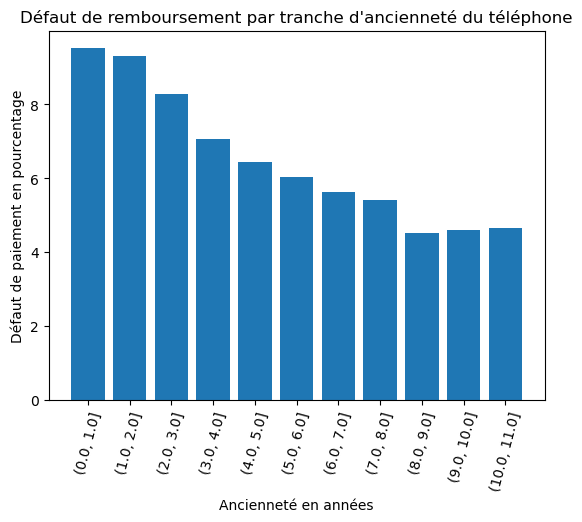

In [40]:
plt.bar(phone_groupe.index.astype(str), phone_groupe['TARGET']*100)
plt.title('Défaut de remboursement par tranche d\'ancienneté du téléphone')
plt.xlabel('Ancienneté en années')
plt.ylabel('Défaut de paiement en pourcentage')
plt.xticks(rotation = 75)
plt.show()

On voit que plus l'ancienneté du téléphone est grande, moins le défaut de paiement est important.

### <a name='1a5'> Séparation du jeu d'entraînement

In [41]:
X_train, X_test, y_train, y_test = train_test_split(app_train.drop('TARGET', axis=1), app_train['TARGET'], test_size=0.2, stratify=app_train['TARGET'], random_state = 0)

In [42]:
y_train.value_counts(normalize = True)

TARGET
0    0.91927
1    0.08073
Name: proportion, dtype: float64

In [43]:
y_test.value_counts(normalize = True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Les proportions sont conservées.

## <a name='1b'> app_test

In [44]:
app_test = pd.read_csv('application_test.csv')
app_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

In [45]:
app_test.shape

(48744, 121)

Le fichier test.

## <a name='1c'> bureau

In [46]:
bur = pd.read_csv('bureau.csv')
bur.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [47]:
bur.shape

(1716428, 17)

Ce fichier référence les 1 716 428 demandes de prêts antérieurs que les clients ont obtenu auprès d'autres banques. Chaque ligne représente un crédit.

In [48]:
bur.loc[bur['SK_ID_CURR'] == 215354]

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0           215354       5714462        Closed      currency 1         -497   
1           215354       5714463        Active      currency 1         -208   
2           215354       5714464        Active      currency 1         -203   
3           215354       5714465        Active      currency 1         -203   
4           215354       5714466        Active      currency 1         -629   
5           215354       5714467        Active      currency 1         -273   
6           215354       5714468        Active      currency 1          -43   
225157      215354       5714458        Closed      currency 1        -1872   
225158      215354       5714459        Closed      currency 1        -1734   
225159      215354       5714460        Closed      currency 1        -1333   
225160      215354       5714461        Closed      currency 1        -1011   

        CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                        0               -153.0             -153.0   
1                        0               1075.0                NaN   
2                        0                528.0                NaN   
3                        0                  NaN                NaN   
4                        0               1197.0                NaN   
5                        0              27460.0                NaN   
6                        0                 79.0                NaN   
225157                   0               -776.0            -1203.0   
225158                   0               -638.0            -1336.0   
225159                   0              -1089.0             -987.0   
225160                   0               -830.0             -770.0   

        AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                          NaN                   0         91323.0   
1                          NaN                   0        225000.0   
2                          NaN                   0        464323.5   
3                          NaN                   0         90000.0   
4                      77674.5                   0       2700000.0   
5                          0.0                   0        180000.0   
6                          0.0                   0         42103.8   
225157                     NaN                   0        494550.0   
225158                     NaN                   0       1084032.0   
225159                     NaN                   0        102150.0   
225160                     NaN                   0        500463.0   

        AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                      0.00                   NaN                     0.0   
1                 171342.00                   NaN                     0.0   
2                       NaN                   NaN                     0.0   
3                       NaN                   NaN                     0.0   
4                       NaN                   NaN                     0.0   
5                  71017.38             108982.62                     0.0   
6                  42103.80                  0.00                     0.0   
225157                 0.00                  0.00                     0.0   
225158                 0.00                   NaN                     0.0   
225159                  NaN                   NaN                     0.0   
225160                  NaN                   NaN                     0.0   

            CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0       Consumer credit                -131          NaN  
1           Credit card                 -20          NaN  
2       Consumer credit                 -16          NaN  
3           Credit card                 -16          NaN  
4       Consumer credit                 -21          NaN  
5           Credit card                 -31          NaN  
6       Consumer credit                

## <a name='1d'> bureau_balance

In [49]:
bureau_bal = pd.read_csv('bureau_balance.csv')
bureau_bal.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [50]:
bureau_bal.shape

(27299925, 3)

In [51]:
bureau_bal['STATUS'].value_counts()

STATUS
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: count, dtype: int64

In [52]:
bureau_bal.loc[bureau_bal['SK_ID_BUREAU'] == 5715448]

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0        5715448               0      C
1        5715448              -1      C
2        5715448              -2      C
3        5715448              -3      C
4        5715448              -4      C
5        5715448              -5      C
6        5715448              -6      C
7        5715448              -7      C
8        5715448              -8      C
9        5715448              -9      0
10       5715448             -10      0
11       5715448             -11      X
12       5715448             -12      X
13       5715448             -13      X
14       5715448             -14      0
15       5715448             -15      0
16       5715448             -16      0
17       5715448             -17      0
18       5715448             -18      0
19       5715448             -19      0
20       5715448             -20      X
21       5715448             -21      X
22       5715448             -22      X
23       5715448             -23      X
24       5715448             -24      X
25       5715448             -25      X
26       5715448             -26      X

MONTHS_BALANCE représente le mois du solde par rapport à la date d'application (-1 signifie la date de solde la plus récente)

STATUS :
   - C signifie fermé
   - X signifie état inconnu
   - 0 signifie pas de DPD (days past due -> jours de retard au cours du mois précédent)
   - 1 signifie DPD entre 1-30
   - 2 signifie DPD 31-60
   - 5 signifie DPD 120+ ou vendu ou radié

Ce fichier représente les crédits précédents. Chaque ligne correspond à un mois d'un crédit précédent.

## <a name='1e'> credit_card_balance

In [53]:
cre_card = pd.read_csv('credit_card_balance.csv')
cre_card.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [54]:
cre_card.shape

(3840312, 23)

Ce fichier donne le solde des cartes de crédit précédentes que les clients ont eues avec Home Credit. Chaque ligne correspond à un mois du solde d'une carte de crédit et une carte peut avoir plusieurs lignes.

## <a name='1f'> HomeCredit_columns_description

In [55]:
home_credit = pd.read_csv('HomeCredit_columns_description.csv', encoding = 'latin-1')
home_credit.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

In [56]:
home_credit.shape

(219, 5)

Ce fichier donne les descriptions des variables utilisées dans les autres fichiers

In [57]:
set(sorted(home_credit['Row'].to_list()))

{'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_BALANCE',
 'AMT_CREDIT',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_CREDIT_MAX_OVERDUE',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'AMT_DOWN_PAYMENT',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_INSTALMENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_TOTAL_RECEIVABLE',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CHANNEL_TYPE',
 'CNT_CHILDREN',
 'CNT_CREDIT_PROLONG',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_CURRENT',


## <a name='1g'> installments_payments

In [58]:
ins_pay = pd.read_csv('installments_payments.csv')
ins_pay.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [59]:
ins_pay.shape

(13605401, 8)

Ce fichier donne des informations sur les paiements pour les prêts précédents. Une ligne représente un paiement ou un paiement non effectué.

## <a name='1h'> POS_CASH_balance

In [60]:
pos_ca = pd.read_csv('POS_CASH_balance.csv')
pos_ca.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [61]:
pos_ca.shape

(10001358, 8)

Ce fichier donne des informations sur les crédits précédents par rapport à la demande SK_ID_CURR :
  - MONTHS_BALANCE : mois du solde par rapport à la date de la demande
  - CNT_INSTALMENT : durée du crédit
  - CNT_INSTALMENT_FUTURE : nombre de versements restant à payer

## <a name='1i'> previous_application

In [62]:
prev_app = pd.read_csv('previous_application.csv')
prev_app.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [63]:
prev_app.shape

(1670214, 37)

Ce fichier donne des informations sur les demandes précédentes de crédit (une ligne par demande) :
   - AMT_ANNUITY : apport
   - AMT_APPLICATION : montant demandé
   - AMT_CREDIT : montant accordé
   - AMT_GOODS_PRICE : coût du bien
   - FLAG_LAST_APPL_PER_CONTRACT : indique s'il s'agit de la dernière demande

## <a name='1j'> sample_submission

In [64]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub.head()

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

In [65]:
sample_sub.shape

(48744, 2)

Exemple de fichier attendu.

## <a name='2'> Feature engineering

In [66]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes('object').columns.to_list()
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    df = X_train.copy()
    df['TARGET'] = y_train
    test_df = X_test.copy()
    df = pd.concat([df, test_df], ignore_index=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./credit_card_balance.csv', nrows = num_rows)
    cc.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis= 1, inplace = True)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category)
    # General aggregations
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [67]:
num_rows = 10000
df = application_train_test(num_rows)

bureau = bureau_and_balance(num_rows)
df = df.join(bureau, how='left', on='SK_ID_CURR', rsuffix='_right')

prev = previous_applications(num_rows)
df = df.join(prev, how='left', on='SK_ID_CURR', rsuffix='_right')

pos = pos_cash(num_rows)
df = df.join(pos, how='left', on='SK_ID_CURR', rsuffix='_right')

ins = installments_payments(num_rows)
df = df.join(ins, how='left', on='SK_ID_CURR', rsuffix='_right')

cc = credit_card_balance(num_rows)
df = df.join(cc, how='left', on='SK_ID_CURR', rsuffix='_right')

X_train = df[df['TARGET'].notnull()]
X_test = df[df['TARGET'].isnull()]

In [68]:
y_train = X_train['TARGET']
X_train = X_train.drop('TARGET', axis=1)
X_test = X_test.drop('TARGET', axis=1)

In [69]:
X_train.shape, y_train.shape

((246005, 738), (246005,))

In [70]:
X_test.shape, y_test.shape

((61502, 738), (61502,))

## <a name='3'> 3) MLTracking

In [71]:
# Enregistrement de la run mlflow
def create_experiment(experiment_name, run_name, run_metrics, model, confusion_matrix_path = None, 
                      roc_auc_plot_path = None, run_params = None):
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name = run_name):
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
            
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')
            
        mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("beta_scorer", beta)
        mlflow.set_tag("seuil", seuil_proba)
        mlflow.set_tag("fraction_sample", frac)
                            
    print('Run - %s is logged to Experiment - %s' %(run_name, experiment_name))

In [72]:
# Enregistrement des scores sur le train_set
def score_train(model, grid, grid_params, run_name, experiment_name):
    mlflow.set_experiment(experiment_name)
    results = grid.cv_results_
    
    for i in range(len(results['params'])):
        with mlflow.start_run(run_name = run_name + str(i)) as run:  

            mlflow.log_param("folds", grid.cv)

            params = list(grid_params.keys())
            for param in params:
                mlflow.log_param(param, results["param_%s" % param][i])

            for score_name in [score for score in results if "mean_test" in score]:
                mlflow.log_metric(score_name, results[score_name][i])
                mlflow.log_metric(score_name.replace("mean","std"), results[score_name.replace("mean","std")][i])

## <a name='4'> 4) Modélisation

In [73]:
# Création d'un score pour diminuer le nombre de faux négatifs
beta = 3
scorer = make_scorer(fbeta_score, beta = beta)

In [74]:
# Création d'un score métier
def score_metier(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10*fn + fp

In [75]:
# Fonction pour récupérer les scores 
def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    metier = score_metier(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return {'score_metier': metier, 'accuracy': round(acc, 2),
            'precision': round(prec, 2), 'recall': round(recall, 2), 'f1_score': round(f_score,2), 'auc': auc}

In [76]:
# création et sauvegarde de la courbe roc
def create_roc_auc_plot(clf, x_data, y_data, run_name):
    name = run_name + '_roc_auc_curve.png'
    RocCurveDisplay.from_estimator(clf, x_data, y_data) 
    plt.savefig(name)
    return name

In [77]:
# création et sauvegarde de la matrice de confusion
def create_confusion_matrix_plot(y_true, y_pred, run_name):
    name = run_name + '_confusion_matrix.png'
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.savefig(name)
    return name

In [78]:
seuil_proba = 0.5
def seuil(estimator, X):
    proba = estimator.predict_proba(X)
    return np.where(proba[:,0] >= seuil_proba, 0, 1)

In [79]:
def create_model(clf, run_name, X, y, params):
    # oversampling
    #oversample = SMOTE()
    #X, y = oversample.fit_resample(X, y)
    
    clf.fit(X, y)
    y_pred = seuil(clf, X_test)
    run_metrics = get_metrics(y_test, y_pred)
    name_curve = create_roc_auc_plot(clf, X, y, run_name)
    name_conf_mat = create_confusion_matrix_plot(y_test, y_pred, run_name)
    create_experiment('scoring_P7', run_name, run_metrics, model, name_conf_mat, name_curve, params)

In [80]:
def create_model_grid(model, run_name, params, X_sample, y_sample, X_test):
    time_0 = time.time()
    
    # oversampling
    #oversample = SMOTE()
    #X_sample, y_sample = oversample.fit_resample(X_sample, y_sample)
    
    # GridSearch
    grid = RandomizedSearchCV(model, param_distributions = params, scoring = scorer, cv = 5)
    grid.fit(X_sample, y_sample)
    
    # Scores sur le jeu d'entraînement
    grid_params = grid.param_distributions
    score_train(model, grid, grid_params, run_name, 'scoring_P7')
    
    # Scores du meilleur estimateur
    best_params = grid.best_params_
    estimator = grid.best_estimator_
    y_pred = seuil(estimator, X_test)
    run_metrics = get_metrics(y_test, y_pred)
    name_curve = create_roc_auc_plot(estimator, X_sample, y_sample, run_name)
    name_conf_mat = create_confusion_matrix_plot(y_test, y_pred, run_name)
    
    create_experiment('scoring_P7', run_name, run_metrics, estimator, name_conf_mat, name_curve, best_params)
    
    duration = time.time() - time_0
    print(f'Durée : {duration} s')

### Création d'un échantillon

In [81]:
data = X_train.copy()
data['TARGET'] = y_train

frac = 0.25
sample_data = data.sample(frac=frac)

X_sample = sample_data.drop('TARGET', axis=1)
y_sample = sample_data['TARGET']

In [82]:
X_sample.shape, y_sample.shape

((61501, 738), (61501,))

In [83]:
y_sample.value_counts(normalize=True)

TARGET
0.0    0.919953
1.0    0.080047
Name: proportion, dtype: float64

### Imputation des valeurs manquantes par la médiane

In [84]:
imputer = SimpleImputer(strategy = 'median')
X_sample_imputed = imputer.fit_transform(X_sample)
X_test_imputed = imputer.transform(X_test)

### Class_weight

In [85]:
class_weights = {0:1, 1:10}  # Poids de la classe 0 à 1, Poids de la classe 1 à 10

### <a name='4a'> Dummy Classifier

D:\anaconda3\envs\projet7\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run - DummyClassifier is logged to Experiment - scoring_P7


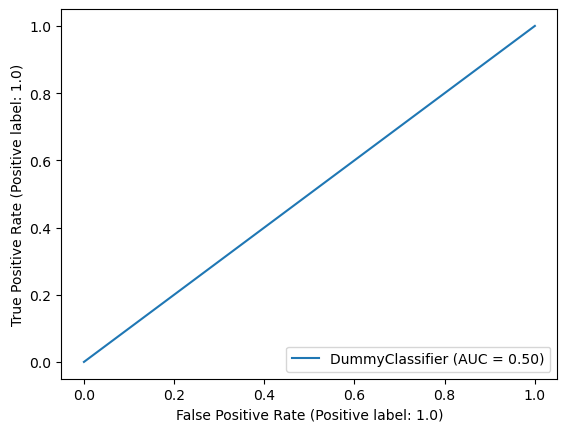

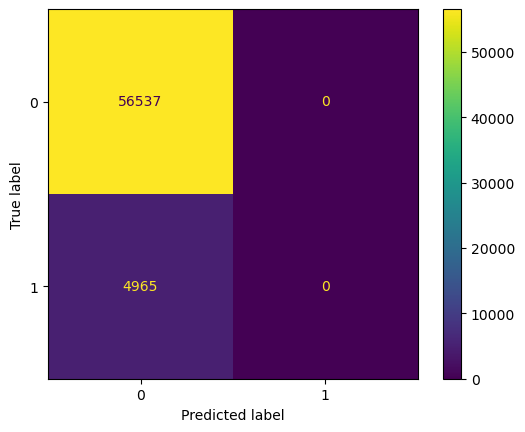

In [88]:
model = DummyClassifier()
create_model(model, 'DummyClassifier')

### <a name='4b'> Regression logistique

penalty : Terme de pénalité utilisé dans la fonction de perte. Vous pouvez choisir entre "l1", "l2", "elasticnet" ou "none". Les pénalités L1 et L2 sont couramment utilisées pour la régularisation.

C : Inverse de la force de régularisation. Une valeur plus petite de C correspond à une régularisation plus forte. Vous pouvez expérimenter avec différentes valeurs de C pour trouver le bon compromis entre l'ajustement du modèle et la régularisation.

solver : Algorithme utilisé pour optimiser les poids. Différents solveurs sont disponibles, tels que "liblinear", "newton-cg", "lbfgs", "sag" et "saga". Le choix du solveur peut affecter la vitesse de convergence et la performance du modèle.

max_iter : Nombre maximum d'itérations pour la convergence de l'optimiseur. Il s'agit du nombre maximum de fois que l'algorithme itérera pour trouver les poids optimaux.

class_weight : Poids associés aux classes d'entraînement. Cela peut être utilisé pour traiter les déséquilibres de classe en attribuant des poids plus élevés aux classes minoritaires

D:\anaconda3\envs\projet7\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda3\envs\projet7\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda3\envs\projet7\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda3\envs\projet7\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda3\envs\projet7\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

D:\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda3\envs\projet7\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\anaconda3\envs\projet7\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Run - LogisticRegression is logged to Experiment - scoring_P7
Durée : 4190.746408939362 s


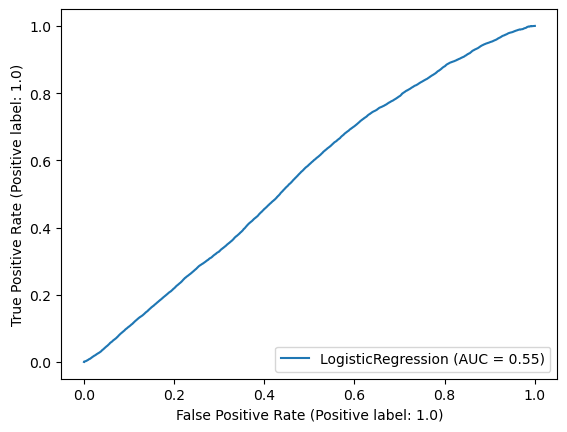

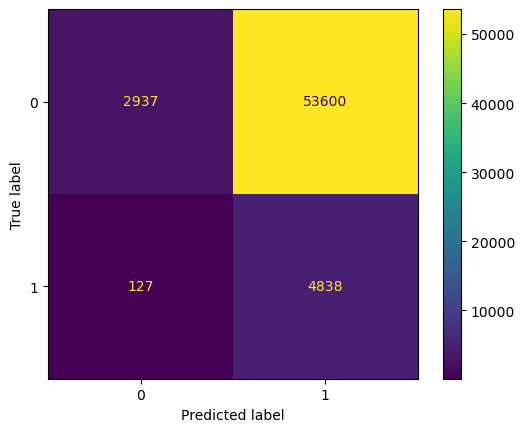

In [91]:
model = LogisticRegression(class_weight = class_weights)
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga'],
    'max_iter': [200, 300],
    'class_weight': [None, 'balanced']
}
create_model_grid(model, 'LogisticRegression', params, X_sample_imputed, y_sample, X_test_imputed)

### <a name='4c'> HistGradientBoostingClassifier

learning_rate : Taux d'apprentissage pour les mises à jour des modèles. Il contrôle la contribution de chaque arbre à l'ensemble final. Des valeurs plus petites réduiront la contribution de chaque arbre et nécessiteront généralement plus d'arbres dans l'ensemble.

max_depth : Profondeur maximale de chaque arbre dans l'ensemble. Augmenter la profondeur peut permettre au modèle de capturer des relations plus complexes, mais peut également augmenter le risque de surajustement.

max_iter : Nombre maximum d'itérations (c'est-à-dire le nombre total d'arbres dans l'ensemble) à effectuer lors de l'ajustement du modèle. Cela peut être utile pour contrôler la complexité du modèle et éviter un ajustement excessif.

max_leaf_nodes : Nombre maximum de feuilles dans chaque arbre. Cela peut être utilisé pour contrôler la complexité du modèle en limitant le nombre de feuilles.

min_samples_leaf : Le nombre minimum d'échantillons requis pour former une feuille. Cela peut être utilisé pour contrôler la croissance de l'arbre et éviter le surajustement.

l2_regularization : Terme de régularisation L2 pour contrôler la complexité du modèle et prévenir le surajustement

Run - HistGradientBoosting is logged to Experiment - scoring_P7
Durée : 1227.25004196167 s


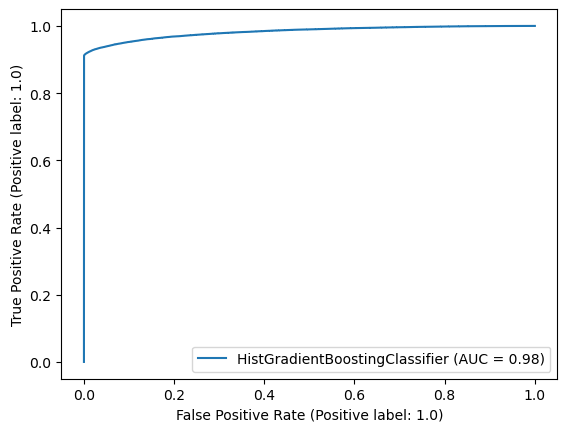

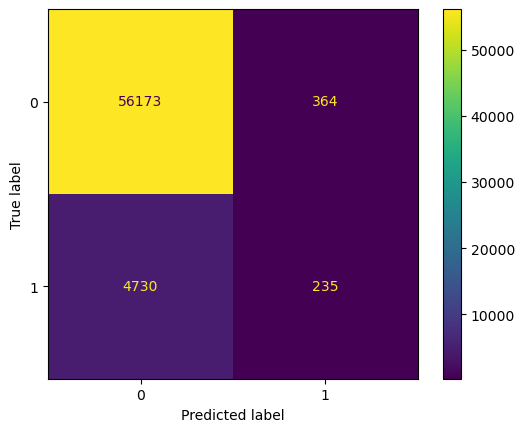

In [87]:
model = HistGradientBoostingClassifier(class_weight = class_weights)
params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'max_iter': [100, 200, 300],
    'max_leaf_nodes': [None, 10, 100],
    'min_samples_leaf': [1, 5, 10],
    'l2_regularization': [0.0, 0.1, 0.01]
}
create_model_grid(model, 'HistGradientBoosting', params, X_sample_imputed, y_sample, X_test_imputed)

### <a name='4d'> KNeighbors Classifier

n_neighbors : Il s'agit du nombre de voisins à considérer pour la classification d'un point. Vous pouvez spécifier une liste de valeurs pour tester différentes options.

weights : Ce paramètre détermine la méthode de pondération des voisins. Les valeurs possibles sont 'uniform' (tous les voisins ont le même poids) et 'distance' (les voisins sont pondérés en fonction de leur distance). Vous pouvez également tester différentes options pour ce paramètre.

p : Il s'agit du paramètre de puissance pour la distance de Minkowski. Si p = 1, la distance de Manhattan est utilisée, et si p = 2, la distance euclidienne est utilisée. Vous pouvez tester différentes valeurs pour ce paramètre.

Run - KNeighborsClassifier is logged to Experiment - scoring_P7
Durée : 4343.743539810181 s


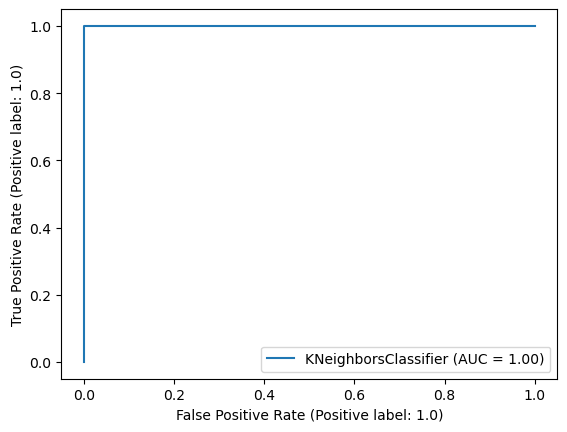

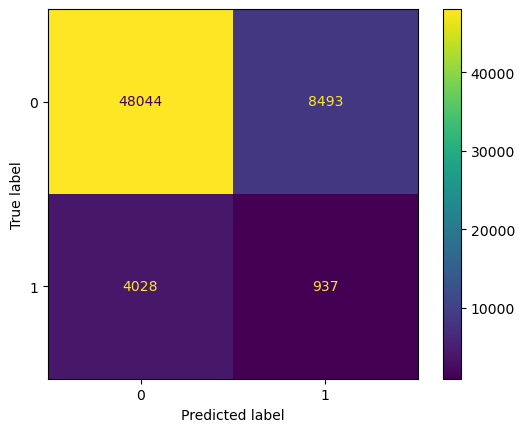

In [100]:
model = KNeighborsClassifier()
params = {
    'n_neighbors': [1,5,9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
create_model_grid(model, 'KNeighborsClassifier', params, X_sample_imputed, y_sample, X_test_imputed)

### <a name='4e'> CatBoostClassifier

depth: La profondeur maximale de chaque arbre. Une valeur plus élevée peut rendre le modèle plus complexe, mais peut également augmenter le risque de surajustement.

learning_rate: Le taux d'apprentissage contrôle l'ampleur des mises à jour des poids à chaque étape de l'apprentissage. Une valeur plus faible permet généralement un apprentissage plus lent et plus précis.

n_estimators: Le nombre d'estimateurs (arbres) dans l'algorithme de boosting. Une valeur plus élevée peut améliorer les performances du modèle, mais cela peut également augmenter le temps d'entraînement.

subsample: La proportion d'échantillons utilisés pour entraîner chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les données, ce qui peut améliorer la robustesse du modèle face au surajustement.

colsample_bylevel: La proportion de caractéristiques utilisées pour chaque niveau de chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les caractéristiques, ce qui peut réduire la corrélation entre les arbres et améliorer la diversité du modèle.

l2_leaf_reg: Le terme de régularisation L2 qui pénalise les poids des nœuds de l'arbre. Une valeur plus élevée favorise une réduction plus importante des poids, ce qui peut prévenir le surajustement.

border_count: Le nombre de partitions pour les valeurs continues. Une valeur plus élevée peut améliorer la précision du modèle, mais cela augmente également la complexité et le temps d'entraînement.

random_strength: Le contrôle de la force de la régularisation aléatoire. Une valeur plus élevée peut renforcer la régularisation aléatoire, ce qui peut améliorer la robustesse du modèle.

0:	learn: 0.5422332	total: 269ms	remaining: 1m 20s
1:	learn: 0.4259105	total: 302ms	remaining: 45s
2:	learn: 0.3606232	total: 333ms	remaining: 32.9s
3:	learn: 0.3084784	total: 362ms	remaining: 26.8s
4:	learn: 0.2608474	total: 391ms	remaining: 23.1s
5:	learn: 0.2308979	total: 418ms	remaining: 20.5s
6:	learn: 0.2015051	total: 446ms	remaining: 18.7s
7:	learn: 0.1711250	total: 476ms	remaining: 17.4s
8:	learn: 0.1471239	total: 504ms	remaining: 16.3s
9:	learn: 0.1260947	total: 535ms	remaining: 15.5s
10:	learn: 0.1094907	total: 562ms	remaining: 14.8s
11:	learn: 0.0962031	total: 589ms	remaining: 14.1s
12:	learn: 0.0834337	total: 617ms	remaining: 13.6s
13:	learn: 0.0729473	total: 645ms	remaining: 13.2s
14:	learn: 0.0646258	total: 677ms	remaining: 12.9s
15:	learn: 0.0558845	total: 708ms	remaining: 12.6s
16:	learn: 0.0488093	total: 737ms	remaining: 12.3s
17:	learn: 0.0424825	total: 765ms	remaining: 12s
18:	learn: 0.0374345	total: 793ms	remaining: 11.7s
19:	learn: 0.0338105	total: 819ms	remaining:

164:	learn: 0.0019774	total: 4.35s	remaining: 3.56s
165:	learn: 0.0019773	total: 4.37s	remaining: 3.53s
166:	learn: 0.0019773	total: 4.4s	remaining: 3.5s
167:	learn: 0.0019773	total: 4.42s	remaining: 3.47s
168:	learn: 0.0019773	total: 4.44s	remaining: 3.44s
169:	learn: 0.0019768	total: 4.46s	remaining: 3.41s
170:	learn: 0.0019760	total: 4.48s	remaining: 3.38s
171:	learn: 0.0019760	total: 4.5s	remaining: 3.35s
172:	learn: 0.0019759	total: 4.52s	remaining: 3.32s
173:	learn: 0.0019710	total: 4.54s	remaining: 3.29s
174:	learn: 0.0019710	total: 4.56s	remaining: 3.26s
175:	learn: 0.0019709	total: 4.58s	remaining: 3.23s
176:	learn: 0.0019709	total: 4.6s	remaining: 3.2s
177:	learn: 0.0019709	total: 4.62s	remaining: 3.17s
178:	learn: 0.0019709	total: 4.64s	remaining: 3.14s
179:	learn: 0.0019709	total: 4.67s	remaining: 3.11s
180:	learn: 0.0019709	total: 4.69s	remaining: 3.08s
181:	learn: 0.0019708	total: 4.71s	remaining: 3.05s
182:	learn: 0.0019708	total: 4.73s	remaining: 3.02s
183:	learn: 0.001

30:	learn: 0.1716493	total: 911ms	remaining: 7.9s
31:	learn: 0.1711509	total: 941ms	remaining: 7.88s
32:	learn: 0.1707757	total: 965ms	remaining: 7.81s
33:	learn: 0.1703646	total: 996ms	remaining: 7.79s
34:	learn: 0.1700123	total: 1.03s	remaining: 7.83s
35:	learn: 0.1697014	total: 1.06s	remaining: 7.79s
36:	learn: 0.1694036	total: 1.09s	remaining: 7.73s
37:	learn: 0.1683277	total: 1.11s	remaining: 7.69s
38:	learn: 0.1678743	total: 1.14s	remaining: 7.65s
39:	learn: 0.1675747	total: 1.17s	remaining: 7.61s
40:	learn: 0.1673596	total: 1.2s	remaining: 7.58s
41:	learn: 0.1670713	total: 1.23s	remaining: 7.56s
42:	learn: 0.1668697	total: 1.26s	remaining: 7.51s
43:	learn: 0.1666295	total: 1.3s	remaining: 7.57s
44:	learn: 0.1664244	total: 1.33s	remaining: 7.52s
45:	learn: 0.1661996	total: 1.35s	remaining: 7.48s
46:	learn: 0.1660060	total: 1.38s	remaining: 7.42s
47:	learn: 0.1657804	total: 1.41s	remaining: 7.38s
48:	learn: 0.1655773	total: 1.44s	remaining: 7.37s
49:	learn: 0.1654349	total: 1.46s	

195:	learn: 0.1517093	total: 4.98s	remaining: 2.64s
196:	learn: 0.1517065	total: 5s	remaining: 2.62s
197:	learn: 0.1516270	total: 5.03s	remaining: 2.59s
198:	learn: 0.1515511	total: 5.05s	remaining: 2.56s
199:	learn: 0.1514401	total: 5.08s	remaining: 2.54s
200:	learn: 0.1513269	total: 5.11s	remaining: 2.52s
201:	learn: 0.1512527	total: 5.13s	remaining: 2.49s
202:	learn: 0.1511986	total: 5.16s	remaining: 2.46s
203:	learn: 0.1511477	total: 5.18s	remaining: 2.44s
204:	learn: 0.1510825	total: 5.21s	remaining: 2.41s
205:	learn: 0.1510038	total: 5.24s	remaining: 2.39s
206:	learn: 0.1509552	total: 5.26s	remaining: 2.36s
207:	learn: 0.1509153	total: 5.29s	remaining: 2.34s
208:	learn: 0.1508026	total: 5.31s	remaining: 2.31s
209:	learn: 0.1507111	total: 5.34s	remaining: 2.29s
210:	learn: 0.1506230	total: 5.37s	remaining: 2.26s
211:	learn: 0.1505423	total: 5.39s	remaining: 2.24s
212:	learn: 0.1504750	total: 5.42s	remaining: 2.21s
213:	learn: 0.1503647	total: 5.45s	remaining: 2.19s
214:	learn: 0.1

57:	learn: 0.1625822	total: 1.7s	remaining: 7.08s
58:	learn: 0.1624465	total: 1.73s	remaining: 7.05s
59:	learn: 0.1623497	total: 1.75s	remaining: 7s
60:	learn: 0.1622283	total: 1.78s	remaining: 6.97s
61:	learn: 0.1620840	total: 1.81s	remaining: 6.94s
62:	learn: 0.1620745	total: 1.83s	remaining: 6.88s
63:	learn: 0.1620676	total: 1.85s	remaining: 6.82s
64:	learn: 0.1619379	total: 1.88s	remaining: 6.79s
65:	learn: 0.1618098	total: 1.91s	remaining: 6.76s
66:	learn: 0.1617766	total: 1.93s	remaining: 6.71s
67:	learn: 0.1609987	total: 1.96s	remaining: 6.68s
68:	learn: 0.1609914	total: 1.98s	remaining: 6.62s
69:	learn: 0.1608477	total: 2.01s	remaining: 6.59s
70:	learn: 0.1606945	total: 2.04s	remaining: 6.58s
71:	learn: 0.1606287	total: 2.07s	remaining: 6.55s
72:	learn: 0.1605044	total: 2.09s	remaining: 6.51s
73:	learn: 0.1604957	total: 2.12s	remaining: 6.46s
74:	learn: 0.1604871	total: 2.14s	remaining: 6.41s
75:	learn: 0.1603529	total: 2.17s	remaining: 6.39s
76:	learn: 0.1602599	total: 2.19s	r

217:	learn: 0.1502303	total: 5.79s	remaining: 2.18s
218:	learn: 0.1501481	total: 5.81s	remaining: 2.15s
219:	learn: 0.1501104	total: 5.83s	remaining: 2.12s
220:	learn: 0.1500653	total: 5.85s	remaining: 2.09s
221:	learn: 0.1500205	total: 5.88s	remaining: 2.06s
222:	learn: 0.1500003	total: 5.9s	remaining: 2.04s
223:	learn: 0.1498817	total: 5.92s	remaining: 2.01s
224:	learn: 0.1498791	total: 5.94s	remaining: 1.98s
225:	learn: 0.1497688	total: 5.97s	remaining: 1.95s
226:	learn: 0.1496940	total: 5.99s	remaining: 1.93s
227:	learn: 0.1496138	total: 6.02s	remaining: 1.9s
228:	learn: 0.1495355	total: 6.05s	remaining: 1.87s
229:	learn: 0.1494738	total: 6.07s	remaining: 1.85s
230:	learn: 0.1494089	total: 6.09s	remaining: 1.82s
231:	learn: 0.1493523	total: 6.11s	remaining: 1.79s
232:	learn: 0.1493027	total: 6.14s	remaining: 1.76s
233:	learn: 0.1493003	total: 6.16s	remaining: 1.74s
234:	learn: 0.1492608	total: 6.18s	remaining: 1.71s
235:	learn: 0.1488983	total: 6.2s	remaining: 1.68s
236:	learn: 0.1

81:	learn: 0.1601000	total: 2.14s	remaining: 5.68s
82:	learn: 0.1600939	total: 2.15s	remaining: 5.64s
83:	learn: 0.1600055	total: 2.18s	remaining: 5.6s
84:	learn: 0.1599994	total: 2.2s	remaining: 5.56s
85:	learn: 0.1592322	total: 2.23s	remaining: 5.54s
86:	learn: 0.1591316	total: 2.25s	remaining: 5.51s
87:	learn: 0.1590780	total: 2.27s	remaining: 5.47s
88:	learn: 0.1589571	total: 2.3s	remaining: 5.46s
89:	learn: 0.1588114	total: 2.33s	remaining: 5.43s
90:	learn: 0.1587901	total: 2.35s	remaining: 5.39s
91:	learn: 0.1586502	total: 2.38s	remaining: 5.37s
92:	learn: 0.1585111	total: 2.4s	remaining: 5.35s
93:	learn: 0.1585015	total: 2.43s	remaining: 5.32s
94:	learn: 0.1583911	total: 2.45s	remaining: 5.29s
95:	learn: 0.1583861	total: 2.47s	remaining: 5.25s
96:	learn: 0.1582765	total: 2.49s	remaining: 5.22s
97:	learn: 0.1582068	total: 2.52s	remaining: 5.19s
98:	learn: 0.1582002	total: 2.54s	remaining: 5.15s
99:	learn: 0.1581055	total: 2.56s	remaining: 5.13s
100:	learn: 0.1581006	total: 2.58s	

240:	learn: 0.1485501	total: 5.97s	remaining: 1.46s
241:	learn: 0.1484680	total: 5.99s	remaining: 1.44s
242:	learn: 0.1483488	total: 6.02s	remaining: 1.41s
243:	learn: 0.1483463	total: 6.04s	remaining: 1.39s
244:	learn: 0.1482659	total: 6.07s	remaining: 1.36s
245:	learn: 0.1481615	total: 6.09s	remaining: 1.34s
246:	learn: 0.1481590	total: 6.11s	remaining: 1.31s
247:	learn: 0.1481008	total: 6.14s	remaining: 1.29s
248:	learn: 0.1479738	total: 6.17s	remaining: 1.26s
249:	learn: 0.1479239	total: 6.19s	remaining: 1.24s
250:	learn: 0.1478576	total: 6.21s	remaining: 1.21s
251:	learn: 0.1477887	total: 6.24s	remaining: 1.19s
252:	learn: 0.1477214	total: 6.26s	remaining: 1.16s
253:	learn: 0.1476607	total: 6.29s	remaining: 1.14s
254:	learn: 0.1475508	total: 6.32s	remaining: 1.11s
255:	learn: 0.1475442	total: 6.34s	remaining: 1.09s
256:	learn: 0.1474629	total: 6.36s	remaining: 1.06s
257:	learn: 0.1474192	total: 6.39s	remaining: 1.04s
258:	learn: 0.1473212	total: 6.41s	remaining: 1.01s
259:	learn: 

101:	learn: 0.1588390	total: 2.8s	remaining: 5.44s
102:	learn: 0.1587156	total: 2.83s	remaining: 5.42s
103:	learn: 0.1586248	total: 2.86s	remaining: 5.39s
104:	learn: 0.1584901	total: 2.89s	remaining: 5.37s
105:	learn: 0.1583851	total: 2.92s	remaining: 5.34s
106:	learn: 0.1579185	total: 2.94s	remaining: 5.31s
107:	learn: 0.1578809	total: 2.97s	remaining: 5.28s
108:	learn: 0.1578760	total: 2.99s	remaining: 5.24s
109:	learn: 0.1578709	total: 3.01s	remaining: 5.2s
110:	learn: 0.1578650	total: 3.03s	remaining: 5.16s
111:	learn: 0.1577655	total: 3.06s	remaining: 5.13s
112:	learn: 0.1577608	total: 3.08s	remaining: 5.09s
113:	learn: 0.1575921	total: 3.11s	remaining: 5.08s
114:	learn: 0.1574671	total: 3.14s	remaining: 5.05s
115:	learn: 0.1574623	total: 3.16s	remaining: 5.02s
116:	learn: 0.1573802	total: 3.19s	remaining: 4.99s
117:	learn: 0.1573032	total: 3.21s	remaining: 4.96s
118:	learn: 0.1572984	total: 3.23s	remaining: 4.92s
119:	learn: 0.1572028	total: 3.26s	remaining: 4.89s
120:	learn: 0.

260:	learn: 0.1468301	total: 6.8s	remaining: 1.02s
261:	learn: 0.1467933	total: 6.83s	remaining: 991ms
262:	learn: 0.1467119	total: 6.86s	remaining: 965ms
263:	learn: 0.1466208	total: 6.9s	remaining: 941ms
264:	learn: 0.1465640	total: 6.92s	remaining: 915ms
265:	learn: 0.1465557	total: 6.95s	remaining: 888ms
266:	learn: 0.1465086	total: 6.97s	remaining: 862ms
267:	learn: 0.1465068	total: 6.99s	remaining: 835ms
268:	learn: 0.1464183	total: 7.02s	remaining: 809ms
269:	learn: 0.1463933	total: 7.04s	remaining: 782ms
270:	learn: 0.1462861	total: 7.07s	remaining: 756ms
271:	learn: 0.1461967	total: 7.09s	remaining: 730ms
272:	learn: 0.1461544	total: 7.12s	remaining: 704ms
273:	learn: 0.1461401	total: 7.14s	remaining: 678ms
274:	learn: 0.1460931	total: 7.17s	remaining: 652ms
275:	learn: 0.1460007	total: 7.2s	remaining: 626ms
276:	learn: 0.1459335	total: 7.22s	remaining: 600ms
277:	learn: 0.1458447	total: 7.25s	remaining: 574ms
278:	learn: 0.1457987	total: 7.27s	remaining: 548ms
279:	learn: 0.1

123:	learn: 0.0574984	total: 10.3s	remaining: 14.7s
124:	learn: 0.0567859	total: 10.4s	remaining: 14.6s
125:	learn: 0.0559858	total: 10.5s	remaining: 14.5s
126:	learn: 0.0551290	total: 10.6s	remaining: 14.4s
127:	learn: 0.0541904	total: 10.7s	remaining: 14.4s
128:	learn: 0.0535365	total: 10.8s	remaining: 14.3s
129:	learn: 0.0526550	total: 10.8s	remaining: 14.2s
130:	learn: 0.0518951	total: 10.9s	remaining: 14.1s
131:	learn: 0.0512231	total: 11s	remaining: 14s
132:	learn: 0.0505851	total: 11.1s	remaining: 13.9s
133:	learn: 0.0497682	total: 11.2s	remaining: 13.8s
134:	learn: 0.0490799	total: 11.2s	remaining: 13.7s
135:	learn: 0.0484746	total: 11.3s	remaining: 13.7s
136:	learn: 0.0479097	total: 11.4s	remaining: 13.6s
137:	learn: 0.0472468	total: 11.5s	remaining: 13.5s
138:	learn: 0.0465658	total: 11.6s	remaining: 13.4s
139:	learn: 0.0457631	total: 11.7s	remaining: 13.3s
140:	learn: 0.0451087	total: 11.7s	remaining: 13.2s
141:	learn: 0.0444336	total: 11.8s	remaining: 13.1s
142:	learn: 0.04

282:	learn: 0.0088560	total: 23s	remaining: 1.38s
283:	learn: 0.0088017	total: 23s	remaining: 1.3s
284:	learn: 0.0087304	total: 23.1s	remaining: 1.22s
285:	learn: 0.0086578	total: 23.2s	remaining: 1.14s
286:	learn: 0.0085850	total: 23.3s	remaining: 1.05s
287:	learn: 0.0085244	total: 23.3s	remaining: 973ms
288:	learn: 0.0084468	total: 23.4s	remaining: 891ms
289:	learn: 0.0083878	total: 23.5s	remaining: 810ms
290:	learn: 0.0083337	total: 23.6s	remaining: 729ms
291:	learn: 0.0082873	total: 23.6s	remaining: 648ms
292:	learn: 0.0082281	total: 23.7s	remaining: 567ms
293:	learn: 0.0081741	total: 23.8s	remaining: 486ms
294:	learn: 0.0081253	total: 23.9s	remaining: 404ms
295:	learn: 0.0080729	total: 23.9s	remaining: 323ms
296:	learn: 0.0080196	total: 24s	remaining: 243ms
297:	learn: 0.0079497	total: 24.1s	remaining: 162ms
298:	learn: 0.0078788	total: 24.2s	remaining: 80.8ms
299:	learn: 0.0078078	total: 24.2s	remaining: 0us
0:	learn: 0.6759420	total: 89.8ms	remaining: 26.8s
1:	learn: 0.6585002	t

143:	learn: 0.1873939	total: 12.3s	remaining: 13.3s
144:	learn: 0.1869747	total: 12.4s	remaining: 13.2s
145:	learn: 0.1865292	total: 12.4s	remaining: 13.1s
146:	learn: 0.1861287	total: 12.5s	remaining: 13s
147:	learn: 0.1857237	total: 12.6s	remaining: 12.9s
148:	learn: 0.1853608	total: 12.7s	remaining: 12.9s
149:	learn: 0.1850458	total: 12.8s	remaining: 12.8s
150:	learn: 0.1846442	total: 12.9s	remaining: 12.7s
151:	learn: 0.1842287	total: 12.9s	remaining: 12.6s
152:	learn: 0.1838344	total: 13s	remaining: 12.5s
153:	learn: 0.1835229	total: 13.1s	remaining: 12.4s
154:	learn: 0.1831931	total: 13.2s	remaining: 12.4s
155:	learn: 0.1828049	total: 13.3s	remaining: 12.3s
156:	learn: 0.1824249	total: 13.4s	remaining: 12.2s
157:	learn: 0.1820675	total: 13.4s	remaining: 12.1s
158:	learn: 0.1817150	total: 13.5s	remaining: 12s
159:	learn: 0.1814165	total: 13.6s	remaining: 11.9s
160:	learn: 0.1810891	total: 13.7s	remaining: 11.8s
161:	learn: 0.1807955	total: 13.8s	remaining: 11.7s
162:	learn: 0.1804

3:	learn: 0.6281345	total: 333ms	remaining: 24.7s
4:	learn: 0.6140547	total: 415ms	remaining: 24.5s
5:	learn: 0.5987841	total: 503ms	remaining: 24.6s
6:	learn: 0.5849125	total: 587ms	remaining: 24.6s
7:	learn: 0.5714041	total: 671ms	remaining: 24.5s
8:	learn: 0.5593657	total: 755ms	remaining: 24.4s
9:	learn: 0.5478709	total: 839ms	remaining: 24.3s
10:	learn: 0.5364175	total: 922ms	remaining: 24.2s
11:	learn: 0.5258560	total: 1.01s	remaining: 24.2s
12:	learn: 0.5153257	total: 1.09s	remaining: 24.1s
13:	learn: 0.5056785	total: 1.17s	remaining: 24s
14:	learn: 0.4965567	total: 1.26s	remaining: 23.9s
15:	learn: 0.4875842	total: 1.34s	remaining: 23.9s
16:	learn: 0.4778131	total: 1.43s	remaining: 23.8s
17:	learn: 0.4696197	total: 1.51s	remaining: 23.7s
18:	learn: 0.4611452	total: 1.59s	remaining: 23.6s
19:	learn: 0.4528240	total: 1.68s	remaining: 23.5s
20:	learn: 0.4452211	total: 1.76s	remaining: 23.5s
21:	learn: 0.4383416	total: 1.85s	remaining: 23.4s
22:	learn: 0.4303625	total: 1.93s	remain

165:	learn: 0.1793538	total: 13.8s	remaining: 11.1s
166:	learn: 0.1790626	total: 13.9s	remaining: 11.1s
167:	learn: 0.1787587	total: 14s	remaining: 11s
168:	learn: 0.1785201	total: 14.1s	remaining: 10.9s
169:	learn: 0.1782734	total: 14.2s	remaining: 10.8s
170:	learn: 0.1779736	total: 14.2s	remaining: 10.7s
171:	learn: 0.1777120	total: 14.3s	remaining: 10.7s
172:	learn: 0.1774741	total: 14.4s	remaining: 10.6s
173:	learn: 0.1772056	total: 14.5s	remaining: 10.5s
174:	learn: 0.1769393	total: 14.6s	remaining: 10.4s
175:	learn: 0.1767061	total: 14.6s	remaining: 10.3s
176:	learn: 0.1764597	total: 14.7s	remaining: 10.2s
177:	learn: 0.1762001	total: 14.8s	remaining: 10.1s
178:	learn: 0.1759751	total: 14.9s	remaining: 10.1s
179:	learn: 0.1757516	total: 15s	remaining: 9.97s
180:	learn: 0.1755114	total: 15s	remaining: 9.89s
181:	learn: 0.1753078	total: 15.1s	remaining: 9.8s
182:	learn: 0.1750794	total: 15.2s	remaining: 9.72s
183:	learn: 0.1748898	total: 15.3s	remaining: 9.64s
184:	learn: 0.1746935

27:	learn: 0.3965657	total: 2.39s	remaining: 23.2s
28:	learn: 0.3911479	total: 2.48s	remaining: 23.2s
29:	learn: 0.3859079	total: 2.57s	remaining: 23.1s
30:	learn: 0.3810714	total: 2.65s	remaining: 23s
31:	learn: 0.3751937	total: 2.74s	remaining: 22.9s
32:	learn: 0.3704409	total: 2.83s	remaining: 22.9s
33:	learn: 0.3651813	total: 2.91s	remaining: 22.8s
34:	learn: 0.3605304	total: 3s	remaining: 22.7s
35:	learn: 0.3553575	total: 3.08s	remaining: 22.6s
36:	learn: 0.3508288	total: 3.17s	remaining: 22.5s
37:	learn: 0.3465119	total: 3.25s	remaining: 22.4s
38:	learn: 0.3427642	total: 3.33s	remaining: 22.3s
39:	learn: 0.3389191	total: 3.42s	remaining: 22.2s
40:	learn: 0.3349659	total: 3.5s	remaining: 22.1s
41:	learn: 0.3306381	total: 3.58s	remaining: 22s
42:	learn: 0.3266363	total: 3.67s	remaining: 21.9s
43:	learn: 0.3232667	total: 3.75s	remaining: 21.8s
44:	learn: 0.3194908	total: 3.83s	remaining: 21.7s
45:	learn: 0.3159292	total: 3.92s	remaining: 21.6s
46:	learn: 0.3130061	total: 4s	remainin

189:	learn: 0.1730338	total: 16.1s	remaining: 9.31s
190:	learn: 0.1728568	total: 16.2s	remaining: 9.22s
191:	learn: 0.1726825	total: 16.2s	remaining: 9.14s
192:	learn: 0.1725091	total: 16.3s	remaining: 9.06s
193:	learn: 0.1723102	total: 16.4s	remaining: 8.97s
194:	learn: 0.1721604	total: 16.5s	remaining: 8.88s
195:	learn: 0.1719098	total: 16.6s	remaining: 8.8s
196:	learn: 0.1717247	total: 16.7s	remaining: 8.71s
197:	learn: 0.1715473	total: 16.7s	remaining: 8.63s
198:	learn: 0.1713669	total: 16.8s	remaining: 8.54s
199:	learn: 0.1712193	total: 16.9s	remaining: 8.45s
200:	learn: 0.1710658	total: 17s	remaining: 8.37s
201:	learn: 0.1708878	total: 17.1s	remaining: 8.29s
202:	learn: 0.1707360	total: 17.2s	remaining: 8.2s
203:	learn: 0.1705944	total: 17.2s	remaining: 8.11s
204:	learn: 0.1704562	total: 17.3s	remaining: 8.03s
205:	learn: 0.1702955	total: 17.4s	remaining: 7.94s
206:	learn: 0.1701283	total: 17.5s	remaining: 7.86s
207:	learn: 0.1699782	total: 17.6s	remaining: 7.78s
208:	learn: 0.16

51:	learn: 0.2970700	total: 4.54s	remaining: 21.7s
52:	learn: 0.2941467	total: 4.63s	remaining: 21.6s
53:	learn: 0.2916835	total: 4.71s	remaining: 21.5s
54:	learn: 0.2887631	total: 4.79s	remaining: 21.3s
55:	learn: 0.2857920	total: 4.87s	remaining: 21.2s
56:	learn: 0.2833935	total: 4.95s	remaining: 21.1s
57:	learn: 0.2809783	total: 5.03s	remaining: 21s
58:	learn: 0.2785155	total: 5.12s	remaining: 20.9s
59:	learn: 0.2759598	total: 5.2s	remaining: 20.8s
60:	learn: 0.2738496	total: 5.28s	remaining: 20.7s
61:	learn: 0.2714769	total: 5.36s	remaining: 20.6s
62:	learn: 0.2691422	total: 5.44s	remaining: 20.5s
63:	learn: 0.2670820	total: 5.53s	remaining: 20.4s
64:	learn: 0.2649605	total: 5.61s	remaining: 20.3s
65:	learn: 0.2631283	total: 5.69s	remaining: 20.2s
66:	learn: 0.2612085	total: 5.78s	remaining: 20.1s
67:	learn: 0.2591080	total: 5.86s	remaining: 20s
68:	learn: 0.2571679	total: 5.94s	remaining: 19.9s
69:	learn: 0.2553243	total: 6.03s	remaining: 19.8s
70:	learn: 0.2534648	total: 6.11s	re

213:	learn: 0.1695821	total: 18s	remaining: 7.24s
214:	learn: 0.1694429	total: 18.1s	remaining: 7.16s
215:	learn: 0.1693383	total: 18.2s	remaining: 7.07s
216:	learn: 0.1692011	total: 18.3s	remaining: 6.99s
217:	learn: 0.1690846	total: 18.4s	remaining: 6.9s
218:	learn: 0.1689627	total: 18.4s	remaining: 6.82s
219:	learn: 0.1688537	total: 18.5s	remaining: 6.73s
220:	learn: 0.1687236	total: 18.6s	remaining: 6.64s
221:	learn: 0.1685759	total: 18.7s	remaining: 6.56s
222:	learn: 0.1684393	total: 18.8s	remaining: 6.47s
223:	learn: 0.1683105	total: 18.8s	remaining: 6.39s
224:	learn: 0.1681355	total: 18.9s	remaining: 6.3s
225:	learn: 0.1680026	total: 19s	remaining: 6.22s
226:	learn: 0.1678738	total: 19.1s	remaining: 6.13s
227:	learn: 0.1677544	total: 19.1s	remaining: 6.04s
228:	learn: 0.1676387	total: 19.2s	remaining: 5.96s
229:	learn: 0.1675263	total: 19.3s	remaining: 5.88s
230:	learn: 0.1674163	total: 19.4s	remaining: 5.79s
231:	learn: 0.1673057	total: 19.5s	remaining: 5.71s
232:	learn: 0.1671

74:	learn: 0.0030364	total: 10.8s	remaining: 18.1s
75:	learn: 0.0030364	total: 10.9s	remaining: 17.9s
76:	learn: 0.0029555	total: 11.1s	remaining: 17.8s
77:	learn: 0.0029388	total: 11.2s	remaining: 17.6s
78:	learn: 0.0029264	total: 11.4s	remaining: 17.5s
79:	learn: 0.0028565	total: 11.5s	remaining: 17.3s
80:	learn: 0.0028043	total: 11.7s	remaining: 17.2s
81:	learn: 0.0028043	total: 11.8s	remaining: 17s
82:	learn: 0.0028042	total: 12s	remaining: 16.9s
83:	learn: 0.0028005	total: 12.1s	remaining: 16.8s
84:	learn: 0.0028006	total: 12.3s	remaining: 16.7s
85:	learn: 0.0027907	total: 12.5s	remaining: 16.5s
86:	learn: 0.0027453	total: 12.6s	remaining: 16.4s
87:	learn: 0.0027453	total: 12.7s	remaining: 16.2s
88:	learn: 0.0027030	total: 12.9s	remaining: 16.1s
89:	learn: 0.0026888	total: 13s	remaining: 15.9s
90:	learn: 0.0026298	total: 13.2s	remaining: 15.8s
91:	learn: 0.0026041	total: 13.3s	remaining: 15.6s
92:	learn: 0.0025717	total: 13.5s	remaining: 15.5s
93:	learn: 0.0024802	total: 13.6s	rem

34:	learn: 0.1604090	total: 4.99s	remaining: 23.5s
35:	learn: 0.1600063	total: 5.12s	remaining: 23.3s
36:	learn: 0.1595527	total: 5.28s	remaining: 23.2s
37:	learn: 0.1591845	total: 5.4s	remaining: 23s
38:	learn: 0.1588475	total: 5.57s	remaining: 23s
39:	learn: 0.1583685	total: 5.7s	remaining: 22.8s
40:	learn: 0.1581189	total: 5.85s	remaining: 22.7s
41:	learn: 0.1577692	total: 5.96s	remaining: 22.4s
42:	learn: 0.1575555	total: 6.12s	remaining: 22.4s
43:	learn: 0.1571725	total: 6.24s	remaining: 22.1s
44:	learn: 0.1569299	total: 6.4s	remaining: 22s
45:	learn: 0.1563113	total: 6.52s	remaining: 21.8s
46:	learn: 0.1559831	total: 6.68s	remaining: 21.7s
47:	learn: 0.1557450	total: 6.8s	remaining: 21.6s
48:	learn: 0.1554057	total: 6.97s	remaining: 21.5s
49:	learn: 0.1549773	total: 7.1s	remaining: 21.3s
50:	learn: 0.1549646	total: 7.25s	remaining: 21.2s
51:	learn: 0.1549527	total: 7.36s	remaining: 21s
52:	learn: 0.1549413	total: 7.51s	remaining: 20.8s
53:	learn: 0.1546344	total: 7.63s	remaining:

194:	learn: 0.1292639	total: 27.4s	remaining: 703ms
195:	learn: 0.1291486	total: 27.5s	remaining: 562ms
196:	learn: 0.1290220	total: 27.7s	remaining: 422ms
197:	learn: 0.1290132	total: 27.8s	remaining: 281ms
198:	learn: 0.1289658	total: 28s	remaining: 141ms
199:	learn: 0.1287813	total: 28.1s	remaining: 0us
0:	learn: 0.5660922	total: 123ms	remaining: 24.4s
1:	learn: 0.4731364	total: 251ms	remaining: 24.9s
2:	learn: 0.4079915	total: 420ms	remaining: 27.6s
3:	learn: 0.3629986	total: 551ms	remaining: 27s
4:	learn: 0.3236602	total: 712ms	remaining: 27.8s
5:	learn: 0.2924125	total: 844ms	remaining: 27.3s
6:	learn: 0.2683531	total: 1.01s	remaining: 27.9s
7:	learn: 0.2498536	total: 1.13s	remaining: 27.1s
8:	learn: 0.2352543	total: 1.3s	remaining: 27.6s
9:	learn: 0.2240974	total: 1.43s	remaining: 27.2s
10:	learn: 0.2141913	total: 1.59s	remaining: 27.3s
11:	learn: 0.2076225	total: 1.71s	remaining: 26.8s
12:	learn: 0.2004014	total: 1.87s	remaining: 26.9s
13:	learn: 0.1959463	total: 2s	remaining: 

156:	learn: 0.1367527	total: 22.6s	remaining: 6.18s
157:	learn: 0.1365770	total: 22.7s	remaining: 6.03s
158:	learn: 0.1364367	total: 22.9s	remaining: 5.89s
159:	learn: 0.1364196	total: 23s	remaining: 5.74s
160:	learn: 0.1362915	total: 23.1s	remaining: 5.6s
161:	learn: 0.1362850	total: 23.2s	remaining: 5.45s
162:	learn: 0.1361372	total: 23.4s	remaining: 5.31s
163:	learn: 0.1357925	total: 23.5s	remaining: 5.16s
164:	learn: 0.1355079	total: 23.7s	remaining: 5.02s
165:	learn: 0.1354096	total: 23.8s	remaining: 4.87s
166:	learn: 0.1351905	total: 23.9s	remaining: 4.73s
167:	learn: 0.1349073	total: 24.1s	remaining: 4.59s
168:	learn: 0.1347643	total: 24.2s	remaining: 4.44s
169:	learn: 0.1346193	total: 24.3s	remaining: 4.3s
170:	learn: 0.1346102	total: 24.5s	remaining: 4.15s
171:	learn: 0.1342963	total: 24.6s	remaining: 4.01s
172:	learn: 0.1341512	total: 24.8s	remaining: 3.87s
173:	learn: 0.1338850	total: 24.9s	remaining: 3.72s
174:	learn: 0.1337431	total: 25.1s	remaining: 3.58s
175:	learn: 0.13

118:	learn: 0.1417021	total: 17s	remaining: 11.6s
119:	learn: 0.1414352	total: 17.1s	remaining: 11.4s
120:	learn: 0.1411671	total: 17.3s	remaining: 11.3s
121:	learn: 0.1410980	total: 17.4s	remaining: 11.1s
122:	learn: 0.1410789	total: 17.6s	remaining: 11s
123:	learn: 0.1408510	total: 17.7s	remaining: 10.8s
124:	learn: 0.1405899	total: 17.8s	remaining: 10.7s
125:	learn: 0.1402740	total: 18s	remaining: 10.6s
126:	learn: 0.1400962	total: 18.1s	remaining: 10.4s
127:	learn: 0.1397678	total: 18.3s	remaining: 10.3s
128:	learn: 0.1395318	total: 18.4s	remaining: 10.1s
129:	learn: 0.1393418	total: 18.5s	remaining: 9.99s
130:	learn: 0.1391801	total: 18.7s	remaining: 9.86s
131:	learn: 0.1389881	total: 18.8s	remaining: 9.71s
132:	learn: 0.1387917	total: 19s	remaining: 9.57s
133:	learn: 0.1385960	total: 19.1s	remaining: 9.41s
134:	learn: 0.1383234	total: 19.3s	remaining: 9.28s
135:	learn: 0.1380769	total: 19.4s	remaining: 9.12s
136:	learn: 0.1378278	total: 19.6s	remaining: 8.99s
137:	learn: 0.137504

78:	learn: 0.1495553	total: 11.2s	remaining: 17.2s
79:	learn: 0.1493224	total: 11.3s	remaining: 17s
80:	learn: 0.1491229	total: 11.5s	remaining: 16.9s
81:	learn: 0.1489150	total: 11.6s	remaining: 16.7s
82:	learn: 0.1488197	total: 11.8s	remaining: 16.6s
83:	learn: 0.1488131	total: 11.9s	remaining: 16.4s
84:	learn: 0.1485922	total: 12.1s	remaining: 16.3s
85:	learn: 0.1483684	total: 12.2s	remaining: 16.1s
86:	learn: 0.1481212	total: 12.3s	remaining: 16s
87:	learn: 0.1478489	total: 12.4s	remaining: 15.8s
88:	learn: 0.1477622	total: 12.6s	remaining: 15.7s
89:	learn: 0.1476208	total: 12.7s	remaining: 15.5s
90:	learn: 0.1472887	total: 12.9s	remaining: 15.4s
91:	learn: 0.1470942	total: 13s	remaining: 15.3s
92:	learn: 0.1470872	total: 13.1s	remaining: 15.1s
93:	learn: 0.1469250	total: 13.3s	remaining: 14.9s
94:	learn: 0.1467960	total: 13.4s	remaining: 14.8s
95:	learn: 0.1464683	total: 13.5s	remaining: 14.7s
96:	learn: 0.1464624	total: 13.7s	remaining: 14.5s
97:	learn: 0.1463597	total: 13.8s	rem

38:	learn: 0.0077886	total: 1.54s	remaining: 2.41s
39:	learn: 0.0075279	total: 1.57s	remaining: 2.36s
40:	learn: 0.0070677	total: 1.61s	remaining: 2.33s
41:	learn: 0.0069462	total: 1.65s	remaining: 2.28s
42:	learn: 0.0067076	total: 1.69s	remaining: 2.24s
43:	learn: 0.0065749	total: 1.72s	remaining: 2.19s
44:	learn: 0.0062726	total: 1.76s	remaining: 2.15s
45:	learn: 0.0060421	total: 1.79s	remaining: 2.11s
46:	learn: 0.0059568	total: 1.84s	remaining: 2.07s
47:	learn: 0.0055747	total: 1.89s	remaining: 2.04s
48:	learn: 0.0053961	total: 1.92s	remaining: 2s
49:	learn: 0.0052377	total: 1.96s	remaining: 1.96s
50:	learn: 0.0050601	total: 2s	remaining: 1.92s
51:	learn: 0.0048996	total: 2.04s	remaining: 1.88s
52:	learn: 0.0048468	total: 2.08s	remaining: 1.84s
53:	learn: 0.0046885	total: 2.12s	remaining: 1.81s
54:	learn: 0.0046271	total: 2.16s	remaining: 1.77s
55:	learn: 0.0045800	total: 2.2s	remaining: 1.73s
56:	learn: 0.0045516	total: 2.23s	remaining: 1.69s
57:	learn: 0.0045094	total: 2.27s	rema

0:	learn: 0.5726399	total: 40.4ms	remaining: 4s
1:	learn: 0.4731532	total: 81.3ms	remaining: 3.98s
2:	learn: 0.4132397	total: 121ms	remaining: 3.91s
3:	learn: 0.3756537	total: 158ms	remaining: 3.79s
4:	learn: 0.3399514	total: 198ms	remaining: 3.76s
5:	learn: 0.3058406	total: 235ms	remaining: 3.69s
6:	learn: 0.2840539	total: 277ms	remaining: 3.68s
7:	learn: 0.2664861	total: 316ms	remaining: 3.64s
8:	learn: 0.2509270	total: 354ms	remaining: 3.58s
9:	learn: 0.2359522	total: 389ms	remaining: 3.5s
10:	learn: 0.2261883	total: 429ms	remaining: 3.47s
11:	learn: 0.2157486	total: 469ms	remaining: 3.44s
12:	learn: 0.2084996	total: 506ms	remaining: 3.39s
13:	learn: 0.2020961	total: 545ms	remaining: 3.35s
14:	learn: 0.1972229	total: 584ms	remaining: 3.31s
15:	learn: 0.1941547	total: 621ms	remaining: 3.26s
16:	learn: 0.1908972	total: 657ms	remaining: 3.21s
17:	learn: 0.1870164	total: 691ms	remaining: 3.15s
18:	learn: 0.1832094	total: 726ms	remaining: 3.09s
19:	learn: 0.1808386	total: 760ms	remaining

66:	learn: 0.1617232	total: 2.41s	remaining: 1.19s
67:	learn: 0.1616168	total: 2.44s	remaining: 1.15s
68:	learn: 0.1615478	total: 2.47s	remaining: 1.11s
69:	learn: 0.1614871	total: 2.5s	remaining: 1.07s
70:	learn: 0.1614252	total: 2.54s	remaining: 1.03s
71:	learn: 0.1613253	total: 2.57s	remaining: 999ms
72:	learn: 0.1611703	total: 2.6s	remaining: 963ms
73:	learn: 0.1610562	total: 2.64s	remaining: 927ms
74:	learn: 0.1609659	total: 2.67s	remaining: 890ms
75:	learn: 0.1608702	total: 2.7s	remaining: 854ms
76:	learn: 0.1607902	total: 2.74s	remaining: 817ms
77:	learn: 0.1606898	total: 2.77s	remaining: 782ms
78:	learn: 0.1606117	total: 2.81s	remaining: 746ms
79:	learn: 0.1605257	total: 2.84s	remaining: 710ms
80:	learn: 0.1604259	total: 2.87s	remaining: 674ms
81:	learn: 0.1604027	total: 2.9s	remaining: 637ms
82:	learn: 0.1602722	total: 2.94s	remaining: 603ms
83:	learn: 0.1601956	total: 2.98s	remaining: 567ms
84:	learn: 0.1593434	total: 3.01s	remaining: 531ms
85:	learn: 0.1592650	total: 3.04s	r

28:	learn: 0.0426595	total: 639ms	remaining: 1.56s
29:	learn: 0.0397996	total: 660ms	remaining: 1.54s
30:	learn: 0.0369194	total: 682ms	remaining: 1.52s
31:	learn: 0.0344808	total: 702ms	remaining: 1.49s
32:	learn: 0.0323875	total: 723ms	remaining: 1.47s
33:	learn: 0.0306896	total: 744ms	remaining: 1.44s
34:	learn: 0.0288125	total: 766ms	remaining: 1.42s
35:	learn: 0.0277949	total: 786ms	remaining: 1.4s
36:	learn: 0.0260074	total: 807ms	remaining: 1.37s
37:	learn: 0.0248866	total: 831ms	remaining: 1.35s
38:	learn: 0.0231308	total: 855ms	remaining: 1.34s
39:	learn: 0.0219482	total: 876ms	remaining: 1.31s
40:	learn: 0.0207910	total: 897ms	remaining: 1.29s
41:	learn: 0.0199574	total: 920ms	remaining: 1.27s
42:	learn: 0.0192924	total: 940ms	remaining: 1.25s
43:	learn: 0.0189860	total: 959ms	remaining: 1.22s
44:	learn: 0.0181505	total: 982ms	remaining: 1.2s
45:	learn: 0.0178985	total: 1s	remaining: 1.18s
46:	learn: 0.0168392	total: 1.02s	remaining: 1.15s
47:	learn: 0.0162053	total: 1.04s	re

98:	learn: 0.1656749	total: 2.11s	remaining: 21.3ms
99:	learn: 0.1656507	total: 2.13s	remaining: 0us
0:	learn: 0.6017762	total: 24.9ms	remaining: 2.47s
1:	learn: 0.5283602	total: 49.9ms	remaining: 2.44s
2:	learn: 0.4850390	total: 71.8ms	remaining: 2.32s
3:	learn: 0.4365260	total: 96.1ms	remaining: 2.31s
4:	learn: 0.4069771	total: 120ms	remaining: 2.27s
5:	learn: 0.3768727	total: 146ms	remaining: 2.28s
6:	learn: 0.3652328	total: 169ms	remaining: 2.24s
7:	learn: 0.3472315	total: 192ms	remaining: 2.21s
8:	learn: 0.3236692	total: 216ms	remaining: 2.18s
9:	learn: 0.3093341	total: 241ms	remaining: 2.17s
10:	learn: 0.2982111	total: 264ms	remaining: 2.14s
11:	learn: 0.2881116	total: 290ms	remaining: 2.13s
12:	learn: 0.2724838	total: 313ms	remaining: 2.1s
13:	learn: 0.2611469	total: 339ms	remaining: 2.08s
14:	learn: 0.2508878	total: 366ms	remaining: 2.07s
15:	learn: 0.2422481	total: 393ms	remaining: 2.06s
16:	learn: 0.2385980	total: 416ms	remaining: 2.03s
17:	learn: 0.2308723	total: 438ms	remai

68:	learn: 0.1706464	total: 1.49s	remaining: 671ms
69:	learn: 0.1705559	total: 1.51s	remaining: 648ms
70:	learn: 0.1704302	total: 1.53s	remaining: 627ms
71:	learn: 0.1703410	total: 1.55s	remaining: 605ms
72:	learn: 0.1692400	total: 1.57s	remaining: 582ms
73:	learn: 0.1691334	total: 1.59s	remaining: 561ms
74:	learn: 0.1690671	total: 1.61s	remaining: 539ms
75:	learn: 0.1678789	total: 1.64s	remaining: 517ms
76:	learn: 0.1678030	total: 1.66s	remaining: 495ms
77:	learn: 0.1677184	total: 1.68s	remaining: 473ms
78:	learn: 0.1676572	total: 1.7s	remaining: 451ms
79:	learn: 0.1675903	total: 1.72s	remaining: 429ms
80:	learn: 0.1675191	total: 1.74s	remaining: 407ms
81:	learn: 0.1664077	total: 1.76s	remaining: 386ms
82:	learn: 0.1663121	total: 1.78s	remaining: 365ms
83:	learn: 0.1662391	total: 1.8s	remaining: 343ms
84:	learn: 0.1661384	total: 1.83s	remaining: 322ms
85:	learn: 0.1660770	total: 1.85s	remaining: 301ms
86:	learn: 0.1660247	total: 1.87s	remaining: 279ms
87:	learn: 0.1659524	total: 1.89s

33:	learn: 0.0097615	total: 1.1s	remaining: 5.38s
34:	learn: 0.0090952	total: 1.14s	remaining: 5.37s
35:	learn: 0.0087041	total: 1.17s	remaining: 5.31s
36:	learn: 0.0080904	total: 1.2s	remaining: 5.28s
37:	learn: 0.0077454	total: 1.23s	remaining: 5.23s
38:	learn: 0.0073274	total: 1.26s	remaining: 5.19s
39:	learn: 0.0070787	total: 1.28s	remaining: 5.14s
40:	learn: 0.0069119	total: 1.31s	remaining: 5.1s
41:	learn: 0.0065410	total: 1.34s	remaining: 5.05s
42:	learn: 0.0063255	total: 1.37s	remaining: 5.01s
43:	learn: 0.0062283	total: 1.4s	remaining: 4.96s
44:	learn: 0.0058929	total: 1.43s	remaining: 4.93s
45:	learn: 0.0057020	total: 1.46s	remaining: 4.89s
46:	learn: 0.0056230	total: 1.49s	remaining: 4.84s
47:	learn: 0.0055608	total: 1.51s	remaining: 4.79s
48:	learn: 0.0054972	total: 1.55s	remaining: 4.77s
49:	learn: 0.0053002	total: 1.58s	remaining: 4.73s
50:	learn: 0.0052442	total: 1.61s	remaining: 4.7s
51:	learn: 0.0051710	total: 1.64s	remaining: 4.65s
52:	learn: 0.0051004	total: 1.66s	re

193:	learn: 0.0013813	total: 5.75s	remaining: 178ms
194:	learn: 0.0013812	total: 5.78s	remaining: 148ms
195:	learn: 0.0013812	total: 5.81s	remaining: 119ms
196:	learn: 0.0013812	total: 5.84s	remaining: 88.9ms
197:	learn: 0.0013812	total: 5.86s	remaining: 59.2ms
198:	learn: 0.0013812	total: 5.89s	remaining: 29.6ms
199:	learn: 0.0013811	total: 5.92s	remaining: 0us
0:	learn: 0.5812627	total: 32.5ms	remaining: 6.47s
1:	learn: 0.4929064	total: 66.2ms	remaining: 6.55s
2:	learn: 0.4386075	total: 99.9ms	remaining: 6.56s
3:	learn: 0.3872210	total: 133ms	remaining: 6.52s
4:	learn: 0.3485156	total: 169ms	remaining: 6.59s
5:	learn: 0.3158659	total: 200ms	remaining: 6.48s
6:	learn: 0.2914528	total: 236ms	remaining: 6.5s
7:	learn: 0.2755358	total: 270ms	remaining: 6.47s
8:	learn: 0.2619117	total: 303ms	remaining: 6.43s
9:	learn: 0.2473682	total: 333ms	remaining: 6.33s
10:	learn: 0.2385490	total: 368ms	remaining: 6.32s
11:	learn: 0.2283582	total: 397ms	remaining: 6.22s
12:	learn: 0.2192591	total: 429

155:	learn: 0.1540500	total: 4.67s	remaining: 1.32s
156:	learn: 0.1534680	total: 4.7s	remaining: 1.29s
157:	learn: 0.1533866	total: 4.73s	remaining: 1.26s
158:	learn: 0.1532881	total: 4.76s	remaining: 1.23s
159:	learn: 0.1532836	total: 4.78s	remaining: 1.2s
160:	learn: 0.1532427	total: 4.81s	remaining: 1.17s
161:	learn: 0.1531293	total: 4.84s	remaining: 1.14s
162:	learn: 0.1530478	total: 4.87s	remaining: 1.11s
163:	learn: 0.1529525	total: 4.9s	remaining: 1.07s
164:	learn: 0.1528672	total: 4.93s	remaining: 1.04s
165:	learn: 0.1527795	total: 4.96s	remaining: 1.01s
166:	learn: 0.1527251	total: 4.99s	remaining: 987ms
167:	learn: 0.1527175	total: 5.02s	remaining: 956ms
168:	learn: 0.1526452	total: 5.05s	remaining: 927ms
169:	learn: 0.1525811	total: 5.08s	remaining: 897ms
170:	learn: 0.1525211	total: 5.11s	remaining: 867ms
171:	learn: 0.1524608	total: 5.14s	remaining: 837ms
172:	learn: 0.1523673	total: 5.18s	remaining: 808ms
173:	learn: 0.1522850	total: 5.2s	remaining: 778ms
174:	learn: 0.15

119:	learn: 0.1573331	total: 3.67s	remaining: 2.45s
120:	learn: 0.1572912	total: 3.71s	remaining: 2.42s
121:	learn: 0.1572850	total: 3.73s	remaining: 2.38s
122:	learn: 0.1572179	total: 3.76s	remaining: 2.35s
123:	learn: 0.1571084	total: 3.79s	remaining: 2.32s
124:	learn: 0.1570179	total: 3.82s	remaining: 2.29s
125:	learn: 0.1568968	total: 3.84s	remaining: 2.26s
126:	learn: 0.1568295	total: 3.87s	remaining: 2.23s
127:	learn: 0.1567277	total: 3.9s	remaining: 2.19s
128:	learn: 0.1566164	total: 3.93s	remaining: 2.16s
129:	learn: 0.1565285	total: 3.96s	remaining: 2.13s
130:	learn: 0.1563747	total: 3.99s	remaining: 2.1s
131:	learn: 0.1563003	total: 4.01s	remaining: 2.07s
132:	learn: 0.1562201	total: 4.04s	remaining: 2.04s
133:	learn: 0.1561415	total: 4.07s	remaining: 2s
134:	learn: 0.1561354	total: 4.1s	remaining: 1.97s
135:	learn: 0.1560584	total: 4.13s	remaining: 1.94s
136:	learn: 0.1560527	total: 4.15s	remaining: 1.91s
137:	learn: 0.1559482	total: 4.18s	remaining: 1.88s
138:	learn: 0.1559

79:	learn: 0.1601320	total: 2.67s	remaining: 4.01s
80:	learn: 0.1601237	total: 2.7s	remaining: 3.97s
81:	learn: 0.1600363	total: 2.73s	remaining: 3.93s
82:	learn: 0.1600232	total: 2.76s	remaining: 3.89s
83:	learn: 0.1599824	total: 2.79s	remaining: 3.86s
84:	learn: 0.1598239	total: 2.83s	remaining: 3.83s
85:	learn: 0.1597208	total: 2.86s	remaining: 3.79s
86:	learn: 0.1596299	total: 2.89s	remaining: 3.75s
87:	learn: 0.1595546	total: 2.92s	remaining: 3.71s
88:	learn: 0.1594392	total: 2.95s	remaining: 3.68s
89:	learn: 0.1594336	total: 2.98s	remaining: 3.64s
90:	learn: 0.1593071	total: 3.01s	remaining: 3.61s
91:	learn: 0.1591555	total: 3.04s	remaining: 3.57s
92:	learn: 0.1590670	total: 3.08s	remaining: 3.54s
93:	learn: 0.1589450	total: 3.11s	remaining: 3.51s
94:	learn: 0.1588314	total: 3.15s	remaining: 3.48s
95:	learn: 0.1587850	total: 3.17s	remaining: 3.44s
96:	learn: 0.1587032	total: 3.21s	remaining: 3.4s
97:	learn: 0.1586295	total: 3.23s	remaining: 3.37s
98:	learn: 0.1585325	total: 3.27s

41:	learn: 0.1671907	total: 1.34s	remaining: 5.06s
42:	learn: 0.1669127	total: 1.38s	remaining: 5.04s
43:	learn: 0.1666547	total: 1.41s	remaining: 5s
44:	learn: 0.1664488	total: 1.44s	remaining: 4.96s
45:	learn: 0.1662438	total: 1.47s	remaining: 4.91s
46:	learn: 0.1659915	total: 1.5s	remaining: 4.9s
47:	learn: 0.1657845	total: 1.54s	remaining: 4.88s
48:	learn: 0.1655220	total: 1.58s	remaining: 4.86s
49:	learn: 0.1653461	total: 1.61s	remaining: 4.82s
50:	learn: 0.1644658	total: 1.64s	remaining: 4.8s
51:	learn: 0.1642917	total: 1.67s	remaining: 4.76s
52:	learn: 0.1641739	total: 1.7s	remaining: 4.73s
53:	learn: 0.1639866	total: 1.73s	remaining: 4.69s
54:	learn: 0.1638515	total: 1.76s	remaining: 4.65s
55:	learn: 0.1637161	total: 1.79s	remaining: 4.61s
56:	learn: 0.1635680	total: 1.83s	remaining: 4.58s
57:	learn: 0.1633799	total: 1.87s	remaining: 4.58s
58:	learn: 0.1632590	total: 1.9s	remaining: 4.54s
59:	learn: 0.1630973	total: 1.93s	remaining: 4.5s
60:	learn: 0.1629902	total: 1.96s	remain

9:	learn: 0.5965130	total: 238ms	remaining: 2.14s
10:	learn: 0.5870046	total: 262ms	remaining: 2.12s
11:	learn: 0.5805108	total: 283ms	remaining: 2.08s
12:	learn: 0.5711959	total: 307ms	remaining: 2.06s
13:	learn: 0.5640894	total: 332ms	remaining: 2.04s
14:	learn: 0.5580522	total: 354ms	remaining: 2.01s
15:	learn: 0.5494828	total: 380ms	remaining: 1.99s
16:	learn: 0.5438526	total: 402ms	remaining: 1.96s
17:	learn: 0.5354483	total: 426ms	remaining: 1.94s
18:	learn: 0.5292309	total: 450ms	remaining: 1.92s
19:	learn: 0.5239804	total: 472ms	remaining: 1.89s
20:	learn: 0.5163676	total: 497ms	remaining: 1.87s
21:	learn: 0.5090841	total: 521ms	remaining: 1.84s
22:	learn: 0.5043513	total: 542ms	remaining: 1.81s
23:	learn: 0.4985980	total: 566ms	remaining: 1.79s
24:	learn: 0.4941517	total: 588ms	remaining: 1.76s
25:	learn: 0.4887842	total: 611ms	remaining: 1.74s
26:	learn: 0.4817307	total: 634ms	remaining: 1.72s
27:	learn: 0.4767037	total: 657ms	remaining: 1.69s
28:	learn: 0.4726143	total: 680m

78:	learn: 0.3585986	total: 1.96s	remaining: 522ms
79:	learn: 0.3569592	total: 1.99s	remaining: 497ms
80:	learn: 0.3552985	total: 2.01s	remaining: 473ms
81:	learn: 0.3536161	total: 2.04s	remaining: 447ms
82:	learn: 0.3513368	total: 2.06s	remaining: 423ms
83:	learn: 0.3504290	total: 2.09s	remaining: 398ms
84:	learn: 0.3488454	total: 2.11s	remaining: 373ms
85:	learn: 0.3467229	total: 2.13s	remaining: 348ms
86:	learn: 0.3442158	total: 2.16s	remaining: 322ms
87:	learn: 0.3427000	total: 2.18s	remaining: 297ms
88:	learn: 0.3407654	total: 2.2s	remaining: 272ms
89:	learn: 0.3385081	total: 2.23s	remaining: 247ms
90:	learn: 0.3366860	total: 2.25s	remaining: 223ms
91:	learn: 0.3346690	total: 2.28s	remaining: 198ms
92:	learn: 0.3332431	total: 2.3s	remaining: 173ms
93:	learn: 0.3314398	total: 2.33s	remaining: 148ms
94:	learn: 0.3306244	total: 2.35s	remaining: 124ms
95:	learn: 0.3289091	total: 2.37s	remaining: 98.9ms
96:	learn: 0.3275281	total: 2.4s	remaining: 74.2ms
97:	learn: 0.3258624	total: 2.42

44:	learn: 0.4405447	total: 1.09s	remaining: 1.34s
45:	learn: 0.4365858	total: 1.12s	remaining: 1.31s
46:	learn: 0.4327547	total: 1.14s	remaining: 1.29s
47:	learn: 0.4298130	total: 1.17s	remaining: 1.26s
48:	learn: 0.4271619	total: 1.19s	remaining: 1.24s
49:	learn: 0.4234647	total: 1.21s	remaining: 1.21s
50:	learn: 0.4199811	total: 1.24s	remaining: 1.19s
51:	learn: 0.4165354	total: 1.26s	remaining: 1.17s
52:	learn: 0.4152783	total: 1.28s	remaining: 1.14s
53:	learn: 0.4127055	total: 1.31s	remaining: 1.11s
54:	learn: 0.4094890	total: 1.33s	remaining: 1.09s
55:	learn: 0.4062484	total: 1.36s	remaining: 1.07s
56:	learn: 0.4050492	total: 1.38s	remaining: 1.04s
57:	learn: 0.4027548	total: 1.4s	remaining: 1.02s
58:	learn: 0.4015925	total: 1.43s	remaining: 992ms
59:	learn: 0.3985971	total: 1.45s	remaining: 967ms
60:	learn: 0.3964414	total: 1.47s	remaining: 942ms
61:	learn: 0.3933366	total: 1.5s	remaining: 917ms
62:	learn: 0.3910955	total: 1.52s	remaining: 893ms
63:	learn: 0.3899776	total: 1.54s

9:	learn: 0.5984628	total: 245ms	remaining: 7.09s
10:	learn: 0.5903644	total: 269ms	remaining: 7.08s
11:	learn: 0.5801458	total: 294ms	remaining: 7.06s
12:	learn: 0.5706689	total: 319ms	remaining: 7.04s
13:	learn: 0.5644696	total: 343ms	remaining: 7.02s
14:	learn: 0.5552639	total: 368ms	remaining: 6.99s
15:	learn: 0.5495149	total: 391ms	remaining: 6.94s
16:	learn: 0.5427707	total: 416ms	remaining: 6.92s
17:	learn: 0.5342257	total: 441ms	remaining: 6.91s
18:	learn: 0.5262426	total: 464ms	remaining: 6.86s
19:	learn: 0.5182368	total: 488ms	remaining: 6.84s
20:	learn: 0.5130381	total: 512ms	remaining: 6.8s
21:	learn: 0.5073744	total: 535ms	remaining: 6.76s
22:	learn: 0.5017408	total: 560ms	remaining: 6.75s
23:	learn: 0.4947444	total: 584ms	remaining: 6.71s
24:	learn: 0.4894013	total: 606ms	remaining: 6.67s
25:	learn: 0.4822551	total: 630ms	remaining: 6.64s
26:	learn: 0.4778417	total: 654ms	remaining: 6.61s
27:	learn: 0.4735264	total: 676ms	remaining: 6.57s
28:	learn: 0.4686948	total: 700ms

173:	learn: 0.1276365	total: 4.09s	remaining: 2.96s
174:	learn: 0.1266269	total: 4.11s	remaining: 2.93s
175:	learn: 0.1256566	total: 4.13s	remaining: 2.91s
176:	learn: 0.1244724	total: 4.15s	remaining: 2.89s
177:	learn: 0.1232305	total: 4.17s	remaining: 2.86s
178:	learn: 0.1220881	total: 4.2s	remaining: 2.84s
179:	learn: 0.1208828	total: 4.22s	remaining: 2.81s
180:	learn: 0.1198639	total: 4.24s	remaining: 2.79s
181:	learn: 0.1189095	total: 4.26s	remaining: 2.77s
182:	learn: 0.1178342	total: 4.29s	remaining: 2.74s
183:	learn: 0.1168876	total: 4.31s	remaining: 2.72s
184:	learn: 0.1159151	total: 4.33s	remaining: 2.69s
185:	learn: 0.1149916	total: 4.35s	remaining: 2.67s
186:	learn: 0.1139600	total: 4.38s	remaining: 2.64s
187:	learn: 0.1128800	total: 4.4s	remaining: 2.62s
188:	learn: 0.1117255	total: 4.42s	remaining: 2.6s
189:	learn: 0.1110181	total: 4.45s	remaining: 2.57s
190:	learn: 0.1102778	total: 4.47s	remaining: 2.55s
191:	learn: 0.1093629	total: 4.49s	remaining: 2.52s
192:	learn: 0.1

34:	learn: 0.4717097	total: 898ms	remaining: 6.8s
35:	learn: 0.4668684	total: 922ms	remaining: 6.76s
36:	learn: 0.4653599	total: 947ms	remaining: 6.73s
37:	learn: 0.4623087	total: 972ms	remaining: 6.7s
38:	learn: 0.4576552	total: 998ms	remaining: 6.68s
39:	learn: 0.4562524	total: 1.02s	remaining: 6.65s
40:	learn: 0.4529085	total: 1.05s	remaining: 6.62s
41:	learn: 0.4502545	total: 1.07s	remaining: 6.59s
42:	learn: 0.4471865	total: 1.1s	remaining: 6.57s
43:	learn: 0.4429702	total: 1.13s	remaining: 6.55s
44:	learn: 0.4388211	total: 1.15s	remaining: 6.52s
45:	learn: 0.4347731	total: 1.18s	remaining: 6.5s
46:	learn: 0.4334568	total: 1.2s	remaining: 6.46s
47:	learn: 0.4305963	total: 1.23s	remaining: 6.43s
48:	learn: 0.4276768	total: 1.25s	remaining: 6.41s
49:	learn: 0.4239040	total: 1.28s	remaining: 6.38s
50:	learn: 0.4212441	total: 1.3s	remaining: 6.35s
51:	learn: 0.4186899	total: 1.32s	remaining: 6.32s
52:	learn: 0.4151909	total: 1.35s	remaining: 6.29s
53:	learn: 0.4114882	total: 1.37s	rem

199:	learn: 0.2241331	total: 4.93s	remaining: 2.47s
200:	learn: 0.2238794	total: 4.96s	remaining: 2.44s
201:	learn: 0.2233756	total: 4.99s	remaining: 2.42s
202:	learn: 0.2227141	total: 5.01s	remaining: 2.39s
203:	learn: 0.2220768	total: 5.03s	remaining: 2.37s
204:	learn: 0.2214831	total: 5.05s	remaining: 2.34s
205:	learn: 0.2209325	total: 5.07s	remaining: 2.31s
206:	learn: 0.2201620	total: 5.1s	remaining: 2.29s
207:	learn: 0.2199007	total: 5.12s	remaining: 2.26s
208:	learn: 0.2196459	total: 5.14s	remaining: 2.24s
209:	learn: 0.2192145	total: 5.16s	remaining: 2.21s
210:	learn: 0.2189636	total: 5.19s	remaining: 2.19s
211:	learn: 0.2183182	total: 5.21s	remaining: 2.16s
212:	learn: 0.2177443	total: 5.24s	remaining: 2.14s
213:	learn: 0.2173221	total: 5.26s	remaining: 2.11s
214:	learn: 0.2167698	total: 5.29s	remaining: 2.09s
215:	learn: 0.2161640	total: 5.31s	remaining: 2.06s
216:	learn: 0.2156035	total: 5.33s	remaining: 2.04s
217:	learn: 0.2152216	total: 5.36s	remaining: 2.02s
218:	learn: 0

63:	learn: 0.3853353	total: 1.69s	remaining: 6.24s
64:	learn: 0.3833122	total: 1.72s	remaining: 6.21s
65:	learn: 0.3810412	total: 1.75s	remaining: 6.19s
66:	learn: 0.3794753	total: 1.77s	remaining: 6.17s
67:	learn: 0.3775808	total: 1.8s	remaining: 6.13s
68:	learn: 0.3756343	total: 1.82s	remaining: 6.1s
69:	learn: 0.3727157	total: 1.85s	remaining: 6.07s
70:	learn: 0.3717279	total: 1.87s	remaining: 6.03s
71:	learn: 0.3687930	total: 1.89s	remaining: 6s
72:	learn: 0.3669037	total: 1.92s	remaining: 5.97s
73:	learn: 0.3644473	total: 1.95s	remaining: 5.94s
74:	learn: 0.3626848	total: 1.97s	remaining: 5.91s
75:	learn: 0.3601209	total: 2s	remaining: 5.89s
76:	learn: 0.3591697	total: 2.02s	remaining: 5.85s
77:	learn: 0.3568031	total: 2.05s	remaining: 5.83s
78:	learn: 0.3549756	total: 2.08s	remaining: 5.81s
79:	learn: 0.3529462	total: 2.1s	remaining: 5.79s
80:	learn: 0.3503446	total: 2.13s	remaining: 5.76s
81:	learn: 0.3481093	total: 2.15s	remaining: 5.73s
82:	learn: 0.3465403	total: 2.18s	remain

222:	learn: 0.2139899	total: 5.67s	remaining: 1.96s
223:	learn: 0.2136410	total: 5.69s	remaining: 1.93s
224:	learn: 0.2134413	total: 5.71s	remaining: 1.9s
225:	learn: 0.2128585	total: 5.74s	remaining: 1.88s
226:	learn: 0.2124180	total: 5.76s	remaining: 1.85s
227:	learn: 0.2120310	total: 5.78s	remaining: 1.82s
228:	learn: 0.2115543	total: 5.8s	remaining: 1.8s
229:	learn: 0.2111382	total: 5.83s	remaining: 1.77s
230:	learn: 0.2109189	total: 5.85s	remaining: 1.75s
231:	learn: 0.2103271	total: 5.88s	remaining: 1.72s
232:	learn: 0.2099422	total: 5.9s	remaining: 1.7s
233:	learn: 0.2097475	total: 5.92s	remaining: 1.67s
234:	learn: 0.2093423	total: 5.95s	remaining: 1.65s
235:	learn: 0.2091482	total: 5.97s	remaining: 1.62s
236:	learn: 0.2089751	total: 5.99s	remaining: 1.59s
237:	learn: 0.2088096	total: 6.01s	remaining: 1.57s
238:	learn: 0.2086347	total: 6.04s	remaining: 1.54s
239:	learn: 0.2084556	total: 6.06s	remaining: 1.51s
240:	learn: 0.2082733	total: 6.08s	remaining: 1.49s
241:	learn: 0.207

90:	learn: 0.3351944	total: 2.23s	remaining: 5.12s
91:	learn: 0.3329204	total: 2.25s	remaining: 5.09s
92:	learn: 0.3307358	total: 2.27s	remaining: 5.06s
93:	learn: 0.3286859	total: 2.3s	remaining: 5.04s
94:	learn: 0.3278776	total: 2.32s	remaining: 5.01s
95:	learn: 0.3270929	total: 2.34s	remaining: 4.98s
96:	learn: 0.3257102	total: 2.37s	remaining: 4.95s
97:	learn: 0.3243997	total: 2.39s	remaining: 4.93s
98:	learn: 0.3227540	total: 2.42s	remaining: 4.91s
99:	learn: 0.3220019	total: 2.44s	remaining: 4.88s
100:	learn: 0.3200146	total: 2.47s	remaining: 4.86s
101:	learn: 0.3181154	total: 2.49s	remaining: 4.84s
102:	learn: 0.3167178	total: 2.51s	remaining: 4.81s
103:	learn: 0.3157044	total: 2.54s	remaining: 4.79s
104:	learn: 0.3137970	total: 2.57s	remaining: 4.77s
105:	learn: 0.3130978	total: 2.59s	remaining: 4.74s
106:	learn: 0.3124261	total: 2.61s	remaining: 4.72s
107:	learn: 0.3107288	total: 2.64s	remaining: 4.69s
108:	learn: 0.3091211	total: 2.66s	remaining: 4.67s
109:	learn: 0.3078679	t

253:	learn: 0.2063342	total: 6.18s	remaining: 1.12s
254:	learn: 0.2061896	total: 6.2s	remaining: 1.09s
255:	learn: 0.2060453	total: 6.22s	remaining: 1.07s
256:	learn: 0.2056006	total: 6.25s	remaining: 1.04s
257:	learn: 0.2051920	total: 6.27s	remaining: 1.02s
258:	learn: 0.2047600	total: 6.29s	remaining: 996ms
259:	learn: 0.2044017	total: 6.32s	remaining: 972ms
260:	learn: 0.2042745	total: 6.34s	remaining: 947ms
261:	learn: 0.2041502	total: 6.36s	remaining: 923ms
262:	learn: 0.2037436	total: 6.39s	remaining: 899ms
263:	learn: 0.2036101	total: 6.41s	remaining: 874ms
264:	learn: 0.2034570	total: 6.43s	remaining: 849ms
265:	learn: 0.2029969	total: 6.46s	remaining: 825ms
266:	learn: 0.2026205	total: 6.48s	remaining: 801ms
267:	learn: 0.2022820	total: 6.5s	remaining: 776ms
268:	learn: 0.2021573	total: 6.52s	remaining: 752ms
269:	learn: 0.2015704	total: 6.55s	remaining: 728ms
270:	learn: 0.2014420	total: 6.57s	remaining: 703ms
271:	learn: 0.2011205	total: 6.6s	remaining: 679ms
272:	learn: 0.2

115:	learn: 0.2958751	total: 2.84s	remaining: 4.51s
116:	learn: 0.2946342	total: 2.87s	remaining: 4.48s
117:	learn: 0.2934403	total: 2.89s	remaining: 4.46s
118:	learn: 0.2921541	total: 2.92s	remaining: 4.44s
119:	learn: 0.2909345	total: 2.95s	remaining: 4.42s
120:	learn: 0.2892647	total: 2.97s	remaining: 4.39s
121:	learn: 0.2881042	total: 2.99s	remaining: 4.37s
122:	learn: 0.2870312	total: 3.02s	remaining: 4.34s
123:	learn: 0.2856166	total: 3.04s	remaining: 4.32s
124:	learn: 0.2846485	total: 3.06s	remaining: 4.29s
125:	learn: 0.2832088	total: 3.09s	remaining: 4.26s
126:	learn: 0.2818212	total: 3.11s	remaining: 4.23s
127:	learn: 0.2805513	total: 3.13s	remaining: 4.21s
128:	learn: 0.2794755	total: 3.16s	remaining: 4.19s
129:	learn: 0.2777828	total: 3.18s	remaining: 4.16s
130:	learn: 0.2763302	total: 3.21s	remaining: 4.14s
131:	learn: 0.2749589	total: 3.23s	remaining: 4.11s
132:	learn: 0.2744471	total: 3.25s	remaining: 4.08s
133:	learn: 0.2738252	total: 3.28s	remaining: 4.06s
134:	learn: 

277:	learn: 0.1980163	total: 6.57s	remaining: 520ms
278:	learn: 0.1979104	total: 6.59s	remaining: 496ms
279:	learn: 0.1977935	total: 6.62s	remaining: 473ms
280:	learn: 0.1976820	total: 6.64s	remaining: 449ms
281:	learn: 0.1975849	total: 6.66s	remaining: 425ms
282:	learn: 0.1972528	total: 6.68s	remaining: 401ms
283:	learn: 0.1971474	total: 6.7s	remaining: 377ms
284:	learn: 0.1970439	total: 6.72s	remaining: 354ms
285:	learn: 0.1967271	total: 6.74s	remaining: 330ms
286:	learn: 0.1966322	total: 6.76s	remaining: 306ms
287:	learn: 0.1965245	total: 6.78s	remaining: 283ms
288:	learn: 0.1964292	total: 6.81s	remaining: 259ms
289:	learn: 0.1963381	total: 6.83s	remaining: 235ms
290:	learn: 0.1959156	total: 6.85s	remaining: 212ms
291:	learn: 0.1958259	total: 6.87s	remaining: 188ms
292:	learn: 0.1957323	total: 6.89s	remaining: 165ms
293:	learn: 0.1956326	total: 6.92s	remaining: 141ms
294:	learn: 0.1955442	total: 6.94s	remaining: 118ms
295:	learn: 0.1954504	total: 6.96s	remaining: 94ms
296:	learn: 0.

144:	learn: 0.0043272	total: 3.42s	remaining: 1.3s
145:	learn: 0.0043272	total: 3.44s	remaining: 1.27s
146:	learn: 0.0043271	total: 3.46s	remaining: 1.25s
147:	learn: 0.0043143	total: 3.48s	remaining: 1.22s
148:	learn: 0.0043061	total: 3.51s	remaining: 1.2s
149:	learn: 0.0042877	total: 3.53s	remaining: 1.18s
150:	learn: 0.0041860	total: 3.56s	remaining: 1.15s
151:	learn: 0.0041806	total: 3.58s	remaining: 1.13s
152:	learn: 0.0041188	total: 3.6s	remaining: 1.1s
153:	learn: 0.0040471	total: 3.62s	remaining: 1.08s
154:	learn: 0.0039378	total: 3.65s	remaining: 1.06s
155:	learn: 0.0039256	total: 3.67s	remaining: 1.03s
156:	learn: 0.0038515	total: 3.7s	remaining: 1.01s
157:	learn: 0.0037231	total: 3.72s	remaining: 990ms
158:	learn: 0.0036669	total: 3.74s	remaining: 966ms
159:	learn: 0.0036077	total: 3.77s	remaining: 943ms
160:	learn: 0.0035980	total: 3.79s	remaining: 919ms
161:	learn: 0.0035612	total: 3.82s	remaining: 895ms
162:	learn: 0.0035519	total: 3.84s	remaining: 871ms
163:	learn: 0.003

108:	learn: 0.1677543	total: 2.54s	remaining: 2.12s
109:	learn: 0.1677155	total: 2.56s	remaining: 2.09s
110:	learn: 0.1676724	total: 2.58s	remaining: 2.07s
111:	learn: 0.1676628	total: 2.6s	remaining: 2.04s
112:	learn: 0.1676231	total: 2.62s	remaining: 2.02s
113:	learn: 0.1675777	total: 2.65s	remaining: 2s
114:	learn: 0.1675242	total: 2.67s	remaining: 1.97s
115:	learn: 0.1674720	total: 2.69s	remaining: 1.95s
116:	learn: 0.1674081	total: 2.71s	remaining: 1.92s
117:	learn: 0.1673494	total: 2.73s	remaining: 1.9s
118:	learn: 0.1672859	total: 2.75s	remaining: 1.88s
119:	learn: 0.1672369	total: 2.78s	remaining: 1.85s
120:	learn: 0.1671769	total: 2.8s	remaining: 1.83s
121:	learn: 0.1671187	total: 2.82s	remaining: 1.8s
122:	learn: 0.1660163	total: 2.85s	remaining: 1.78s
123:	learn: 0.1659643	total: 2.87s	remaining: 1.76s
124:	learn: 0.1652853	total: 2.9s	remaining: 1.74s
125:	learn: 0.1652252	total: 2.92s	remaining: 1.71s
126:	learn: 0.1651662	total: 2.94s	remaining: 1.69s
127:	learn: 0.165114

74:	learn: 0.1707634	total: 1.74s	remaining: 2.9s
75:	learn: 0.1707019	total: 1.76s	remaining: 2.88s
76:	learn: 0.1705356	total: 1.79s	remaining: 2.86s
77:	learn: 0.1704648	total: 1.81s	remaining: 2.83s
78:	learn: 0.1701420	total: 1.83s	remaining: 2.81s
79:	learn: 0.1700217	total: 1.86s	remaining: 2.79s
80:	learn: 0.1699419	total: 1.88s	remaining: 2.76s
81:	learn: 0.1698896	total: 1.9s	remaining: 2.74s
82:	learn: 0.1697989	total: 1.93s	remaining: 2.71s
83:	learn: 0.1697401	total: 1.95s	remaining: 2.69s
84:	learn: 0.1696841	total: 1.97s	remaining: 2.66s
85:	learn: 0.1696503	total: 1.99s	remaining: 2.63s
86:	learn: 0.1695695	total: 2.01s	remaining: 2.62s
87:	learn: 0.1694873	total: 2.04s	remaining: 2.59s
88:	learn: 0.1694187	total: 2.06s	remaining: 2.57s
89:	learn: 0.1693616	total: 2.08s	remaining: 2.54s
90:	learn: 0.1692973	total: 2.1s	remaining: 2.52s
91:	learn: 0.1692439	total: 2.13s	remaining: 2.5s
92:	learn: 0.1692004	total: 2.15s	remaining: 2.47s
93:	learn: 0.1685364	total: 2.17s	r

36:	learn: 0.1863766	total: 891ms	remaining: 3.92s
37:	learn: 0.1837394	total: 915ms	remaining: 3.9s
38:	learn: 0.1832558	total: 935ms	remaining: 3.86s
39:	learn: 0.1829001	total: 957ms	remaining: 3.83s
40:	learn: 0.1811410	total: 981ms	remaining: 3.8s
41:	learn: 0.1806932	total: 1s	remaining: 3.78s
42:	learn: 0.1802869	total: 1.03s	remaining: 3.75s
43:	learn: 0.1799837	total: 1.05s	remaining: 3.71s
44:	learn: 0.1796567	total: 1.07s	remaining: 3.69s
45:	learn: 0.1794449	total: 1.09s	remaining: 3.66s
46:	learn: 0.1791288	total: 1.11s	remaining: 3.63s
47:	learn: 0.1789158	total: 1.14s	remaining: 3.6s
48:	learn: 0.1786522	total: 1.16s	remaining: 3.58s
49:	learn: 0.1784301	total: 1.19s	remaining: 3.56s
50:	learn: 0.1767984	total: 1.21s	remaining: 3.54s
51:	learn: 0.1766387	total: 1.23s	remaining: 3.51s
52:	learn: 0.1764611	total: 1.25s	remaining: 3.48s
53:	learn: 0.1762943	total: 1.27s	remaining: 3.45s
54:	learn: 0.1760791	total: 1.3s	remaining: 3.42s
55:	learn: 0.1759394	total: 1.32s	rema

0:	learn: 0.6076074	total: 27.2ms	remaining: 5.41s
1:	learn: 0.5390351	total: 53.1ms	remaining: 5.25s
2:	learn: 0.5122647	total: 77.9ms	remaining: 5.12s
3:	learn: 0.4806541	total: 102ms	remaining: 4.98s
4:	learn: 0.4362324	total: 129ms	remaining: 5.01s
5:	learn: 0.4082122	total: 153ms	remaining: 4.95s
6:	learn: 0.3778415	total: 178ms	remaining: 4.91s
7:	learn: 0.3675881	total: 202ms	remaining: 4.86s
8:	learn: 0.3423296	total: 228ms	remaining: 4.84s
9:	learn: 0.3205736	total: 251ms	remaining: 4.78s
10:	learn: 0.3089221	total: 278ms	remaining: 4.78s
11:	learn: 0.2953885	total: 305ms	remaining: 4.77s
12:	learn: 0.2843784	total: 331ms	remaining: 4.76s
13:	learn: 0.2728323	total: 357ms	remaining: 4.75s
14:	learn: 0.2622944	total: 381ms	remaining: 4.69s
15:	learn: 0.2538357	total: 406ms	remaining: 4.67s
16:	learn: 0.2456713	total: 432ms	remaining: 4.65s
17:	learn: 0.2375395	total: 455ms	remaining: 4.6s
18:	learn: 0.2302692	total: 479ms	remaining: 4.56s
19:	learn: 0.2239335	total: 505ms	remai

161:	learn: 0.1621141	total: 3.75s	remaining: 879ms
162:	learn: 0.1620710	total: 3.77s	remaining: 856ms
163:	learn: 0.1620331	total: 3.79s	remaining: 832ms
164:	learn: 0.1620285	total: 3.81s	remaining: 809ms
165:	learn: 0.1619916	total: 3.83s	remaining: 786ms
166:	learn: 0.1619533	total: 3.86s	remaining: 762ms
167:	learn: 0.1619245	total: 3.88s	remaining: 739ms
168:	learn: 0.1619202	total: 3.9s	remaining: 716ms
169:	learn: 0.1618806	total: 3.92s	remaining: 692ms
170:	learn: 0.1618462	total: 3.94s	remaining: 669ms
171:	learn: 0.1618419	total: 3.96s	remaining: 646ms
172:	learn: 0.1618038	total: 3.99s	remaining: 623ms
173:	learn: 0.1617451	total: 4.01s	remaining: 600ms
174:	learn: 0.1617004	total: 4.04s	remaining: 576ms
175:	learn: 0.1616644	total: 4.06s	remaining: 553ms
176:	learn: 0.1616603	total: 4.08s	remaining: 530ms
177:	learn: 0.1616247	total: 4.1s	remaining: 507ms
178:	learn: 0.1615935	total: 4.12s	remaining: 484ms
179:	learn: 0.1615578	total: 4.14s	remaining: 461ms
180:	learn: 0.

22:	learn: 0.1811383	total: 941ms	remaining: 3.15s
23:	learn: 0.1802864	total: 978ms	remaining: 3.1s
24:	learn: 0.1793558	total: 1.02s	remaining: 3.05s
25:	learn: 0.1775722	total: 1.05s	remaining: 3s
26:	learn: 0.1761277	total: 1.1s	remaining: 2.96s
27:	learn: 0.1754675	total: 1.13s	remaining: 2.91s
28:	learn: 0.1749589	total: 1.17s	remaining: 2.87s
29:	learn: 0.1743597	total: 1.21s	remaining: 2.82s
30:	learn: 0.1738288	total: 1.25s	remaining: 2.78s
31:	learn: 0.1734493	total: 1.28s	remaining: 2.72s
32:	learn: 0.1730796	total: 1.32s	remaining: 2.69s
33:	learn: 0.1726952	total: 1.36s	remaining: 2.64s
34:	learn: 0.1717856	total: 1.4s	remaining: 2.59s
35:	learn: 0.1713387	total: 1.43s	remaining: 2.55s
36:	learn: 0.1710579	total: 1.47s	remaining: 2.51s
37:	learn: 0.1708269	total: 1.5s	remaining: 2.46s
38:	learn: 0.1705901	total: 1.54s	remaining: 2.42s
39:	learn: 0.1702576	total: 1.58s	remaining: 2.37s
40:	learn: 0.1700702	total: 1.61s	remaining: 2.32s
41:	learn: 0.1699007	total: 1.65s	rema

86:	learn: 0.1621711	total: 3.24s	remaining: 484ms
87:	learn: 0.1621655	total: 3.27s	remaining: 446ms
88:	learn: 0.1620763	total: 3.31s	remaining: 409ms
89:	learn: 0.1619412	total: 3.35s	remaining: 372ms
90:	learn: 0.1618673	total: 3.38s	remaining: 334ms
91:	learn: 0.1617654	total: 3.42s	remaining: 297ms
92:	learn: 0.1617143	total: 3.45s	remaining: 260ms
93:	learn: 0.1616076	total: 3.48s	remaining: 222ms
94:	learn: 0.1615356	total: 3.52s	remaining: 185ms
95:	learn: 0.1614386	total: 3.56s	remaining: 148ms
96:	learn: 0.1614331	total: 3.59s	remaining: 111ms
97:	learn: 0.1613764	total: 3.62s	remaining: 73.9ms
98:	learn: 0.1612782	total: 3.66s	remaining: 37ms
99:	learn: 0.1612751	total: 3.69s	remaining: 0us
0:	learn: 0.5944486	total: 38.8ms	remaining: 3.84s
1:	learn: 0.5081348	total: 77.3ms	remaining: 3.79s
2:	learn: 0.4312495	total: 123ms	remaining: 3.99s
3:	learn: 0.3839212	total: 163ms	remaining: 3.91s
4:	learn: 0.3492467	total: 206ms	remaining: 3.92s
5:	learn: 0.3204956	total: 244ms	rem

48:	learn: 0.1682120	total: 1.86s	remaining: 1.93s
49:	learn: 0.1679176	total: 1.89s	remaining: 1.89s
50:	learn: 0.1677675	total: 1.93s	remaining: 1.85s
51:	learn: 0.1676299	total: 1.96s	remaining: 1.81s
52:	learn: 0.1674753	total: 2s	remaining: 1.77s
53:	learn: 0.1673150	total: 2.03s	remaining: 1.73s
54:	learn: 0.1671774	total: 2.06s	remaining: 1.69s
55:	learn: 0.1670176	total: 2.1s	remaining: 1.65s
56:	learn: 0.1668993	total: 2.14s	remaining: 1.61s
57:	learn: 0.1667242	total: 2.17s	remaining: 1.57s
58:	learn: 0.1660259	total: 2.21s	remaining: 1.54s
59:	learn: 0.1659420	total: 2.24s	remaining: 1.5s
60:	learn: 0.1658138	total: 2.28s	remaining: 1.46s
61:	learn: 0.1656096	total: 2.32s	remaining: 1.42s
62:	learn: 0.1655158	total: 2.36s	remaining: 1.39s
63:	learn: 0.1648687	total: 2.39s	remaining: 1.35s
64:	learn: 0.1647440	total: 2.43s	remaining: 1.31s
65:	learn: 0.1646960	total: 2.46s	remaining: 1.27s
66:	learn: 0.1645592	total: 2.5s	remaining: 1.23s
67:	learn: 0.1644253	total: 2.54s	rem

111:	learn: 0.1360098	total: 3.57s	remaining: 5.99s
112:	learn: 0.1359093	total: 3.6s	remaining: 5.96s
113:	learn: 0.1358454	total: 3.63s	remaining: 5.93s
114:	learn: 0.1357572	total: 3.66s	remaining: 5.89s
115:	learn: 0.1356596	total: 3.7s	remaining: 5.86s
116:	learn: 0.1355610	total: 3.73s	remaining: 5.83s
117:	learn: 0.1355124	total: 3.75s	remaining: 5.79s
118:	learn: 0.1353920	total: 3.79s	remaining: 5.76s
119:	learn: 0.1352699	total: 3.83s	remaining: 5.74s
120:	learn: 0.1351749	total: 3.86s	remaining: 5.71s
121:	learn: 0.1351679	total: 3.88s	remaining: 5.66s
122:	learn: 0.1350706	total: 3.92s	remaining: 5.63s
123:	learn: 0.1350671	total: 3.94s	remaining: 5.59s
124:	learn: 0.1349610	total: 3.97s	remaining: 5.56s
125:	learn: 0.1349475	total: 4s	remaining: 5.52s
126:	learn: 0.1349120	total: 4.02s	remaining: 5.48s
127:	learn: 0.1348224	total: 4.05s	remaining: 5.45s
128:	learn: 0.1348191	total: 4.08s	remaining: 5.41s
129:	learn: 0.1347481	total: 4.11s	remaining: 5.37s
130:	learn: 0.134

271:	learn: 0.1275417	total: 8.14s	remaining: 838ms
272:	learn: 0.1275016	total: 8.17s	remaining: 808ms
273:	learn: 0.1274389	total: 8.2s	remaining: 779ms
274:	learn: 0.1274376	total: 8.23s	remaining: 748ms
275:	learn: 0.1273977	total: 8.27s	remaining: 719ms
276:	learn: 0.1273352	total: 8.3s	remaining: 689ms
277:	learn: 0.1272771	total: 8.33s	remaining: 659ms
278:	learn: 0.1272771	total: 8.35s	remaining: 629ms
279:	learn: 0.1272233	total: 8.38s	remaining: 599ms
280:	learn: 0.1272181	total: 8.41s	remaining: 569ms
281:	learn: 0.1271934	total: 8.44s	remaining: 538ms
282:	learn: 0.1271340	total: 8.46s	remaining: 509ms
283:	learn: 0.1271208	total: 8.49s	remaining: 478ms
284:	learn: 0.1270688	total: 8.52s	remaining: 449ms
285:	learn: 0.1270498	total: 8.55s	remaining: 418ms
286:	learn: 0.1270144	total: 8.58s	remaining: 389ms
287:	learn: 0.1269599	total: 8.61s	remaining: 359ms
288:	learn: 0.1268965	total: 8.64s	remaining: 329ms
289:	learn: 0.1268949	total: 8.66s	remaining: 299ms
290:	learn: 0.

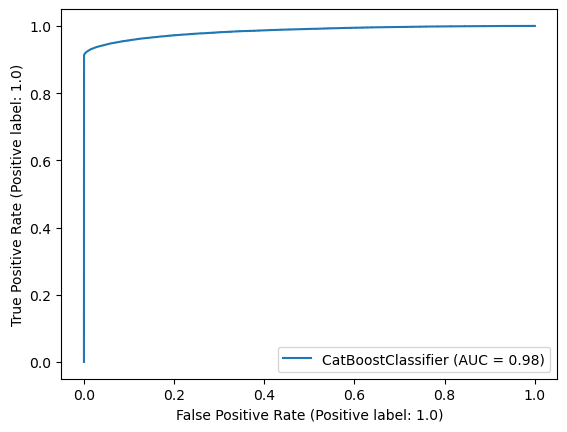

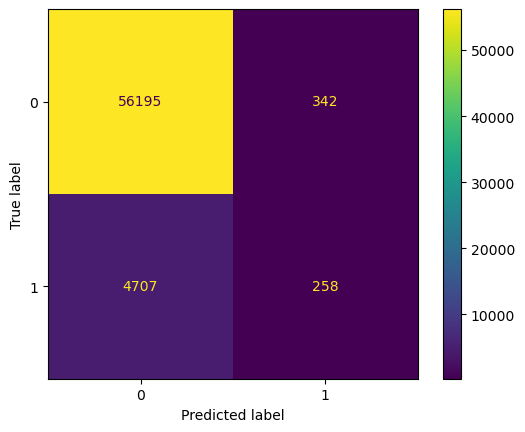

In [88]:
model = CatBoostClassifier(class_weight = [1, 10])
params = {
    'depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bylevel': [0.8, 1.0],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'random_strength': [0.1, 0.5, 1]
}
create_model_grid(model, 'CatBoost', params, X_sample_imputed, y_sample, X_test_imputed)

### <a name='4f'> XGBoost

max_depth: La profondeur maximale de chaque arbre de décision. Une valeur plus élevée peut conduire à un modèle plus complexe, mais cela peut également augmenter le risque de surajustement.

learning_rate: Le taux d'apprentissage contrôle l'ampleur des mises à jour des poids à chaque étape de l'apprentissage. Une valeur plus faible permet généralement un apprentissage plus lent et plus précis.

n_estimators: Le nombre d'estimateurs (arbres) dans l'algorithme de boosting. Une valeur plus élevée peut améliorer les performances du modèle, mais cela peut également augmenter le temps d'entraînement.

subsample: La proportion d'échantillons utilisés pour entraîner chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les données, ce qui peut améliorer la robustesse du modèle face au surajustement.

colsample_bytree: La proportion de caractéristiques utilisées pour entraîner chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les caractéristiques, ce qui peut réduire la corrélation entre les arbres et améliorer la diversité du modèle.

gamma: Le paramètre de régularisation qui contrôle la complexité des arbres. Une valeur plus élevée favorise une réduction plus importante des nœuds de l'arbre, ce qui peut prévenir le surajustement.

reg_alpha et reg_lambda: Les termes de régularisation L1 et L2 qui pénalisent respectivement les valeurs absolues des poids et les carrés des poids. Ils peuvent être utilisés pour contrôler la régularisation du modèle.

min_child_weight: Le poids minimum nécessaire pour créer un nouvel arbre enfant lors de la construction de l'arbre. Une valeur plus élevée peut conduire à un modèle plus conservateur avec moins de divisions.

Run - XGBoost_avec_smote is logged to Experiment - scoring_P7
Durée : 2431.0630650520325 s


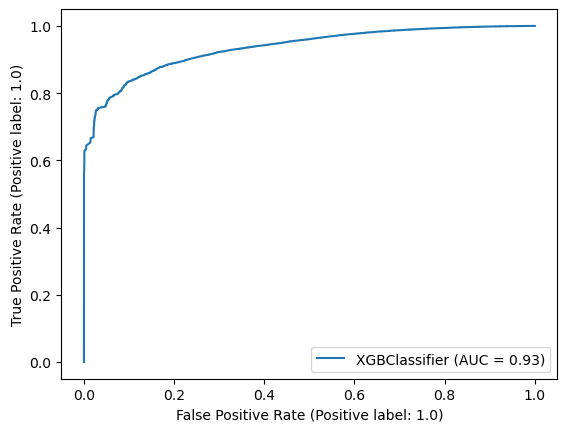

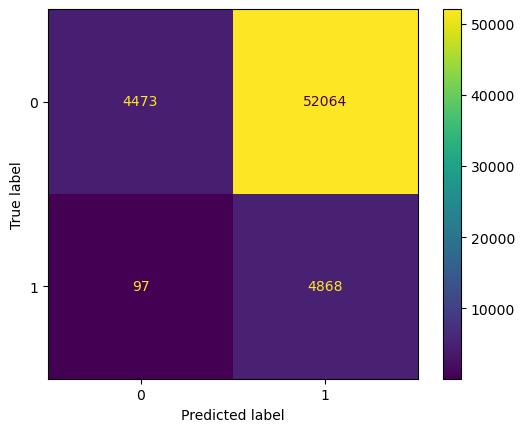

In [123]:
model = XGBClassifier()
params = {
    'scale_pos_weight' : [10],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}
create_model_grid(model, 'XGBoost_avec_smote', params, X_sample_imputed, y_sample, X_test_imputed)

### <a name='4g'> LightGBM

max_depth: La profondeur maximale de chaque arbre. Une valeur plus élevée peut rendre le modèle plus complexe, mais peut également augmenter le risque de surajustement.

learning_rate: Le taux d'apprentissage contrôle l'ampleur des mises à jour des poids à chaque étape de l'apprentissage. Une valeur plus faible permet généralement un apprentissage plus lent et plus précis.

n_estimators: Le nombre d'estimateurs (arbres) dans l'algorithme de boosting. Une valeur plus élevée peut améliorer les performances du modèle, mais cela peut également augmenter le temps d'entraînement.

subsample: La proportion d'échantillons utilisés pour entraîner chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les données, ce qui peut améliorer la robustesse du modèle face au surajustement.

colsample_bytree: La proportion de caractéristiques utilisées pour chaque arbre. Une valeur inférieure à 1.0 permet de sous-échantillonner les caractéristiques, ce qui peut réduire la corrélation entre les arbres et améliorer la diversité du modèle.

reg_alpha et reg_lambda: Les termes de régularisation L1 et L2 qui pénalisent les poids des nœuds de l'arbre. Des valeurs plus élevées favorisent une réduction plus importante des poids, ce qui peut prévenir le surajustement.

min_child_samples: Le nombre minimal d'échantillons requis pour créer un nouveau nœud dans l'arbre. Une valeur plus élevée peut aider à prévenir le surajustement en rendant la construction de l'arbre plus conservatrice.

num_leaves: Le nombre maximal de feuilles dans chaque arbre. Une valeur plus élevée permet à l'arbre d'être plus complexe, mais cela peut également augmenter le risque de surajustement.

Run - LightGBM_avec_smote is logged to Experiment - scoring_P7
Durée : 132.64523196220398 s


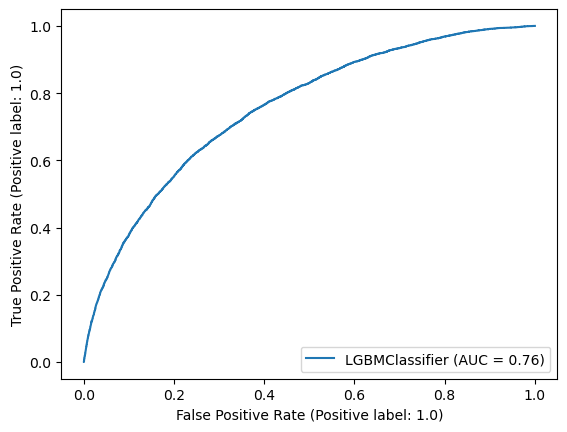

In [98]:
model = LGBMClassifier(class_weight = class_weights)
params = {
    'max_depth': [3, 6, -1],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'min_child_samples': [20, 50, 100],
    'num_leaves': [31, 63, 127]
}
create_model_grid(model, 'LightGBM_avec_smote', params, X_sample_imputed, y_sample, X_test_imputed)

### Fine tuning

In [85]:
def create_model_gridsearch(model, run_name, params, X_sample, y_sample, X_test):
    time_0 = time.time()
    
    # oversampling
    #oversample = SMOTE()
    #X_sample, y_sample = oversample.fit_resample(X_sample, y_sample)
    
    # GridSearch
    grid = GridSearchCV(model, param_grid = params, scoring = scorer, cv = 5)
    grid.fit(X_sample, y_sample)
    
    # Scores sur le jeu d'entraînement
    grid_params = grid.param_grid
    score_train(model, grid, grid_params, run_name, 'scoring_P7')
    
    # Scores du meilleur estimateur
    best_params = grid.best_params_
    estimator = grid.best_estimator_
    y_pred = seuil(estimator, X_test)
    run_metrics = get_metrics(y_test, y_pred)
    name_curve = create_roc_auc_plot(estimator, X_sample, y_sample, run_name)
    name_conf_mat = create_confusion_matrix_plot(y_test, y_pred, run_name)
    
    create_experiment('scoring_P7', run_name, run_metrics, estimator, name_conf_mat, name_curve, best_params)
    
    duration = time.time() - time_0
    print(f'Durée : {duration} s')

D:\anaconda3\envs\projet7\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Run - XGBoost_sans_smote is logged to Experiment - scoring_P7
Durée : 17021.467494249344 s


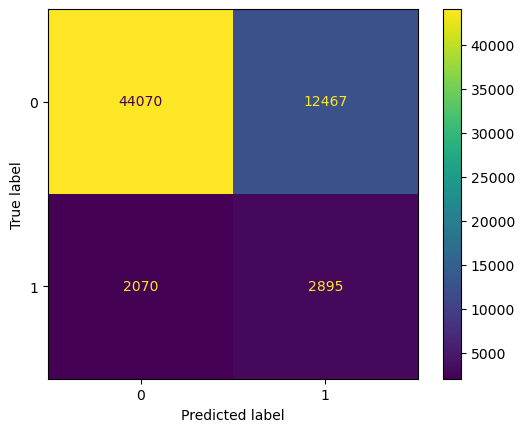

In [86]:
model = XGBClassifier()
params = {
    'scale_pos_weight' : [10],
    'max_depth': [5, 7],
    'learning_rate': [0.1],
    'n_estimators': [150, 200, 250],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'gamma': [0.05, 0.1],
    'reg_alpha': [0],
    'reg_lambda': [0.15, 0.2],
    'min_child_weight': [3, 5]
}
create_model_gridsearch(model, 'XGBoost_sans_smote', params, X_sample, y_sample, X_test)

### <a name='4h'> Modèle retenu

D:\anaconda3\envs\projet7\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Run - XGBClassifier_sans_smote is logged to Experiment - scoring_P7


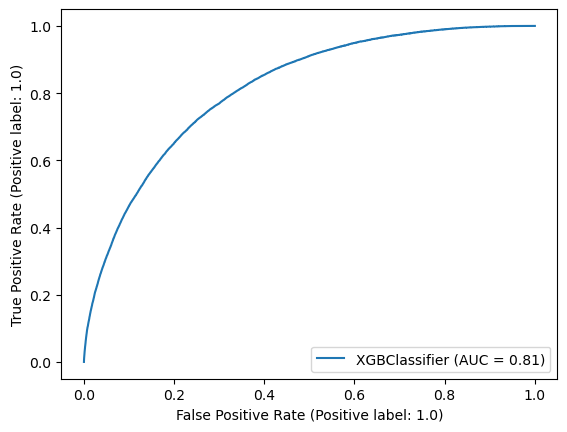

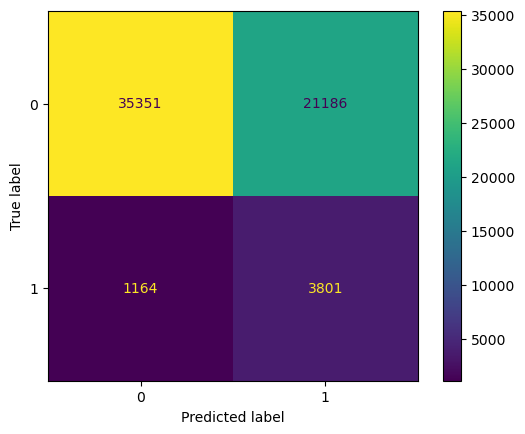

In [86]:
beta = 3
scorer = make_scorer(fbeta_score, beta = beta)
seuil_proba = 0.6

params = {
    'scale_pos_weight':10,
    'max_depth' : 5,
    'learning_rate' : 0.1,
    'n_estimators' : 200,
    'subsample' : 1.0,
    'colsample_bytree' : 1.0,
    'gamma' : 0.1,
    'reg_alpha' : 0,
    'reg_lambda' : 0.15,
    'min_child_weight' : 5
}

model = XGBClassifier(**params)

create_model(model, 'XGBClassifier_sans_smote', X_train, y_train, params)

## <a name='5'> 5) Feature importance

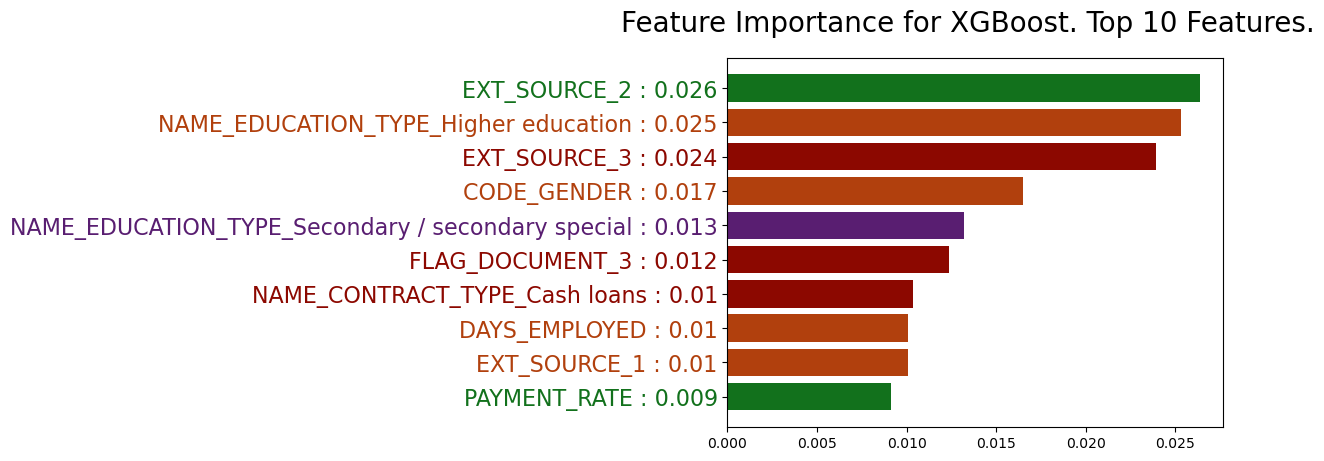

In [87]:
importance = model.feature_importances_
noms_col = X_train.columns

indices = np.argsort(importance)
indices = indices[-10:]

color_list =  sns.color_palette("dark", len(noms_col)) 

plt.barh(range(len(indices)), importance[indices], color= [color_list[indices[i]] for i in range(10)],
         align='center')
  
plt.yticks(range(len(indices)), [(noms_col[j] + ' : ' + str(round(importance[j],3))) for j in indices],
           fontweight="normal", fontsize=16) 

for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])  

plt.suptitle("Feature Importance for XGBoost. Top " + str(10) + " Features.", fontsize=20, fontweight="normal")
plt.show()

In [90]:
shap.initjs()

In [89]:
explainer = shap.TreeExplainer(model)

In [132]:
shap_values = explainer(X_test)

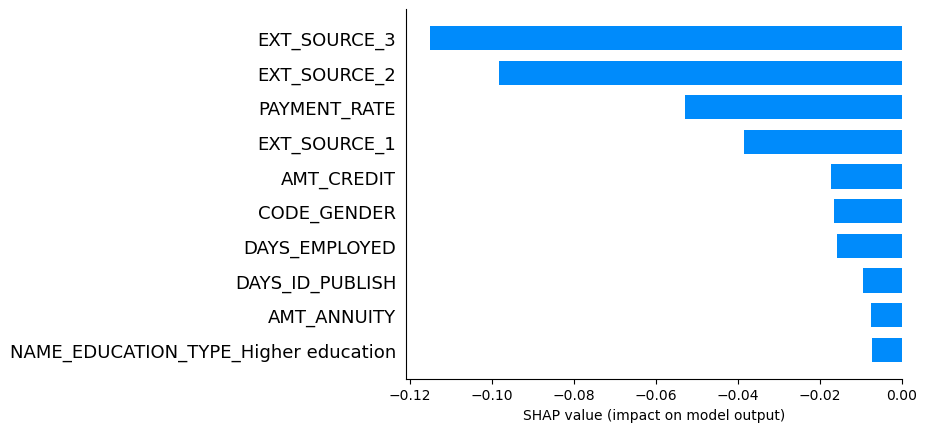

In [130]:
shap.bar_plot(sv,
              feature_names=X_test.columns,
              max_display=10)

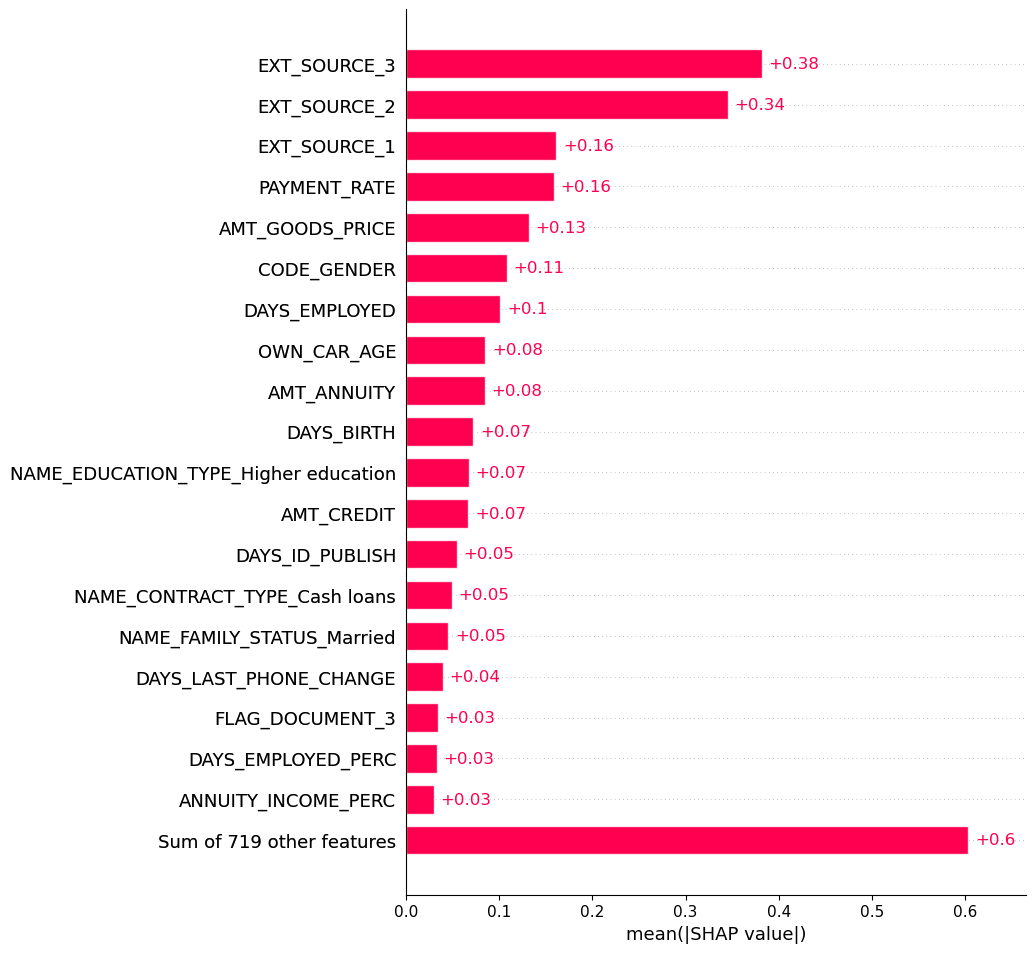

In [106]:
shap.plots.bar(shap_values, max_display = 20)

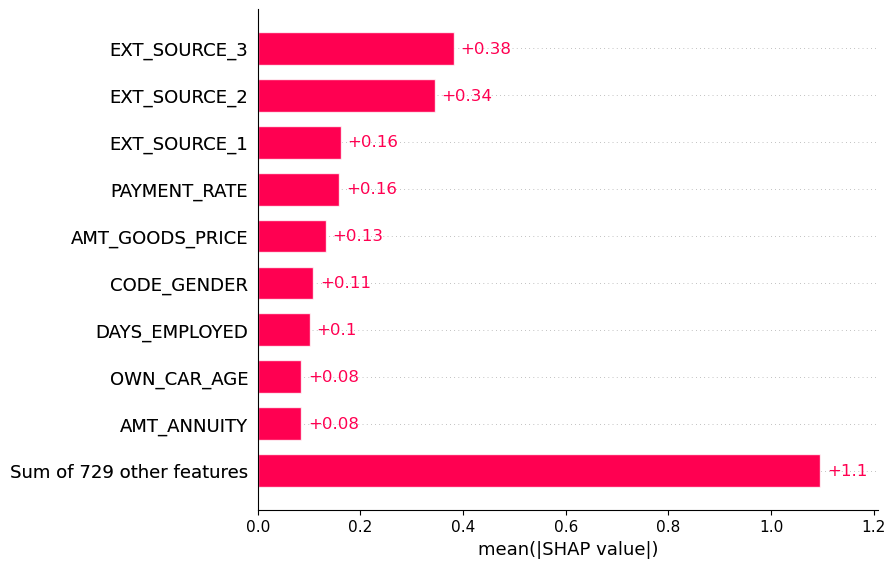

In [118]:
index = 4
shap.plots.bar(shap_values, max_display = 10)

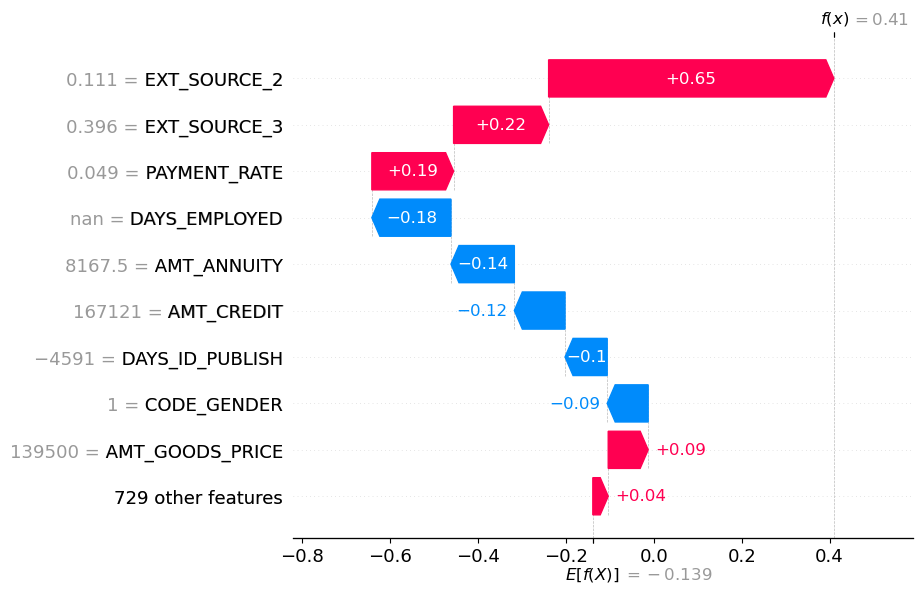

In [104]:
shap.plots.waterfall(shap_values[index])

##  <a name='6'> 6) Sauvegardes

In [102]:
# Sauvegarde du modèle retenu
dump(model, 'best_model.joblib')

['best_model.joblib']

In [130]:
# Sauvegarde du data test
X_test.reset_index(inplace=True, drop = True)
X_test.to_csv('donnees_test.csv',index = False)

In [149]:
# Sauvegarde du data train
X_train['TARGET'] = y_train
X_train.reset_index(inplace= True, drop = True)
X_train.to_csv('donnees_train.csv', index = False)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [151]:
# Sauvegarde d'un échantillon du data_train
X_sample['TARGET'] = y_sample
X_sample.reset_index(inplace= True, drop = True)
X_sample.to_csv('donnees_train_sample.csv', index = False)

In [88]:
# Sauvegarde d'un jeu de 10 données test pour travailler sur le dashboard
X_test_essai = X_test[:10].reset_index(drop = True)
X_test_essai.to_csv('donnees_test_essai.csv', index = False)

In [118]:
# Sauvegarde d'un jeu de 10 données train pour travailler sur le dashboard
X_train['TARGET'] = y_train
X_train_essai = X_train[:10].reset_index(drop = True)
X_train_essai.to_csv('donnees_train_essai.csv', index = False)

## <a name='7'> Data drift

In [76]:
reference = app_train[:5000]
reference = reference.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
current = app_test[:5000]

In [77]:
report = Report(metrics=[
    DataDriftPreset(), 
])

report.run(reference_data=reference, current_data=current)
report

In [78]:
report.save_html('data_drift.html')